# DESI PV Y1 Group/Cluster TFR Calibration

Using the list of groups defined by Tully in [*Galaxy Groups: a 2MASS Catalog*](https://iopscience.iop.org/article/10.1088/0004-6256/149/5/171), AJ 149:171, 2015, identify DESI observations with measurements suitable for calibrating the Tully-Fisher relation. 

Version: **13 Apr 2025**

**Note:** This requires using a subclassed version of `hyperfit`.

Potential updates to this notebook:
* ~~Improved identification of spiral galaxy morphologies in the SGA (currently using LEDA morphological classification).~~
* Larger statistics of SN Ia calibrators with rotation curve measurements and independent distance moduli.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 clusters, so we need to change the default color map so that they are all plotted with different colors
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab10').colors)

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

import ligo.skymap.plot

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
sys.path.insert(1, '/global/homes/m/mjkeller/DESI_SGA/TF')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust

In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')
h = 1.
H0 = 100*h
q0 = 0.2

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [3]:
sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y3'
# sgapath = '.'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_jura_Vrot_VI.fits')

sgatab = Table.read(sgafits)
sgatab[:5]
print(np.sort(sgatab['SGA_ID']))

 SGA_ID
-------
     20
     32
     38
     53
     55
     63
     74
     76
    117
    146
    ...
5002967
5002979
5002994
5003004
5003016
5003025
5003026
5003042
5003044
5003075
5003690
Length = 35682 rows


# Load Morphological Classification using the SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [4]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
# ai_morphpath = '.'
ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab[:5]

<Table length=5>
 SGA_ID Spiral_Pred Elliptical_Pred Lenticular_Pred Irregular_Pred
float64     str6         str10           str10           str9     
------- ----------- --------------- --------------- --------------
 2371.0       Other           Other           Other      Irregular
 2406.0      Spiral           Other           Other          Other
 4614.0      Spiral           Other           Other          Other
 7707.0      Spiral           Other           Other          Other
 8119.0      Spiral           Other           Other          Other

In [5]:
sum(ai_morphtab['Spiral_Pred'] == 'Spiral') + sum(ai_morphtab['Elliptical_Pred'] == 'Elliptical') + sum(ai_morphtab['Lenticular_Pred'] == 'Lenticular') + sum(ai_morphtab['Irregular_Pred'] == 'Irregular')

9710

Cool, so Julia gave us a table with only those objects with certain classifications from all three binary classifiers.  Therefore, if `Spiral_Pred` = 'Spiral', then this is a spiral galaxy.

In [6]:
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Spiral_Pred', 'Elliptical_Pred', 'Lenticular_Pred', 'Irregular_Pred'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')

# Combine ML morphtypes with SGA catalog

In [7]:
'''
#- Match SGA_ID in the two tables and return index into ai_morphtab
idx = np.where(ai_morphtab['SGA_ID'][:, None] == sgatab['SGA_ID'][None, :])[1]

#- Create a new column in the SGA table
sgatab['MORPHTYPE_AI'] = ai_morphtab['Predicted_Type'][idx]
''';

sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection
* $i > 45^\circ$
* Spiral-type morphology

The first three items have already been applied.

In [8]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max
'''
#- Morphology cut: spiral, not S0
is_good_morph = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    try:
        if (sgatab['MORPHTYPE'][i][0] == 'S' and sgatab['MORPHTYPE'][i][:2] != 'S0') or (sgatab['MORPHTYPE_AI'][i][0] == 'S'):
            is_good_morph[i] = True
    except IndexError as e:
        continue
'''
#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- Combine selections:
# is_good_sga = is_good_incl & is_good_morph
is_good_sga = is_good_incl & is_good_morph_ML

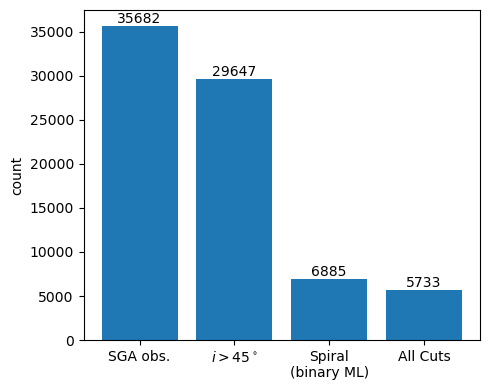

In [9]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(5,4), tight_layout=True)
bars = ax.bar(names, values)
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

# Photometric corrections

### Survey offsets

In [10]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### Dust corrections

In [11]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [12]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/global/homes/m/mjkeller/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [13]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [14]:
# Apparently we have some galaxies with negative redshifts
zg0 = sgatab['Z_DESI'] >= 0

In [15]:
kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
                   [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
                   [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)

In [16]:
kcorr = np.zeros([len(sgatab), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [17]:
temp_infile = open('iron_internalDust_z0p1_mcmc.pickle', 'rb')
dust_mcmc_samples,_ = pickle.load(temp_infile)
temp_infile.close()

In [18]:
internalDust_coeffs = np.median(dust_mcmc_samples, axis=1)

internalDust_coeffs_err = np.zeros(len(internalDust_coeffs))
internalDust_coeffs_err[0] = np.std(dust_mcmc_samples[0][(-1.5 < dust_mcmc_samples[0]) & (dust_mcmc_samples[0] < 0)])
internalDust_coeffs_err[1] = np.std(dust_mcmc_samples[1][(0 < dust_mcmc_samples[1]) & (dust_mcmc_samples[1] < 1)])

In [19]:
internalDust_corr, internalDust_corr_err = internal_dust(sgatab['BA'], 
                                                         internalDust_coeffs, 
                                                         internalDust_coeffs_err)

## Apply corrections

In [20]:
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr

In [21]:
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err**2)

## Load SN Ia Calibrators for the TFR Zero Point

List of SNe Ia from UNION3 and Pantheon+ from Anthony Carr. Match these to the SGA iron observations that have passed all quality cuts.

In [22]:
# zeroptpath = '../cache/'
# zeroptpath = '.'
zeroptpath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/tf_0pt/'
zeroptab = Table.read(os.path.join(zeroptpath, 'SGA_SNmatches+secondary.fits'))

In [23]:
#- Extract the 0-point SNe Ia that match SGA IDs in the good catalog (passed all rotation curve cuts).
#  Merge the tables so we can use the zero point later.
idx = np.in1d(zeroptab['SGA_ID'], sgatab['SGA_ID'][is_good_sga])
# zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx]

zeroptab = join(sgatab, zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx], keys='SGA_ID')

#- Write catalog to file
zeroptab.write('SGA_distances_0pt_iron_z0p1.fits', overwrite=True)
zeroptab[:5]

<Table length=5>
 SGA_ID     SGA_GALAXY            GALAXY         ...  MU_ERR  MU_SOURCE
                                                 ...                   
float64      bytes16             bytes29         ... float64   bytes22 
-------- --------------- ----------------------- ... -------- ---------
 40926.0  SGA-2020 40926              PGC1068066 ...  0.17759 SN2017cjv
103123.0 SGA-2020 103123 SDSSJ074708.56+275429.4 ... 0.251383 SN2017ckx
109750.0 SGA-2020 109750               PGC007299 ... 0.173532    2005hc
124900.0 SGA-2020 124900              PGC1111212 ... 0.149593   PS16ayd
185629.0 SGA-2020 185629              PGC1313612 ... 0.340606    2007ba

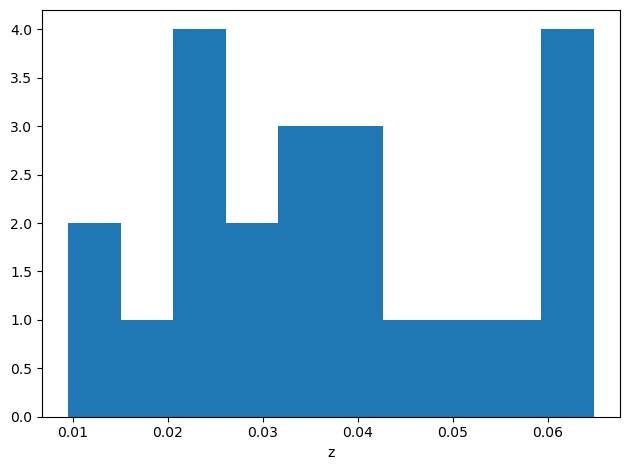

In [24]:
plt.figure(tight_layout=True)

plt.hist(zeroptab['Z_DESI'])

plt.xlabel('z');

In [25]:
# Only keep galaxies with a primary SN match
# zeroptab = zeroptab[~zeroptab['MU_PRIMARY'].mask]

In [26]:
np.unique(zeroptab['MU_SOURCE'], return_counts=True)

(<Column name='MU_SOURCE' dtype='bytes22' length=15>
      1999ac
      2001da
      2001ep
       2002G
      2005hc
      2006bw
      2007ba
 ASASSN-16ct
   AT2017cfc
     PS15cms
     PS16axi
     PS16ayd
     PS16bnz
   SN2017cjv
   SN2017ckx,
 array([1, 1, 1, 1, 1, 1, 2, 1, 4, 1, 2, 2, 2, 1, 1]))

### Plot the Zero Point Calibrators

Sky coordinates of the SNe with good DESI rotational velocities.

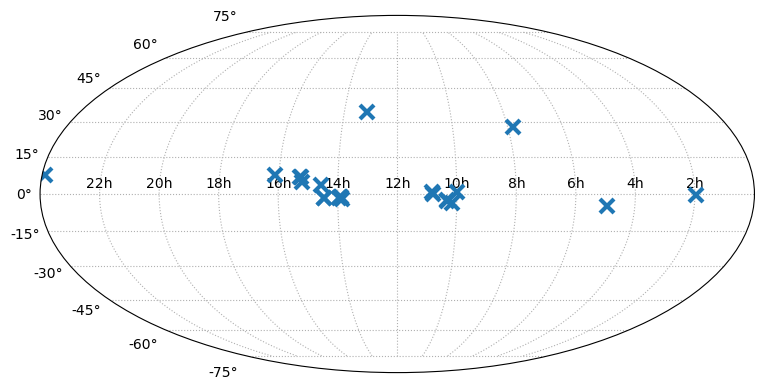

In [27]:
sne_coords = SkyCoord(ra=zeroptab['RA'], dec=zeroptab['DEC'], frame='icrs', unit='deg')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
_ra = np.radians(180*u.deg - sne_coords.ra)
_dec = np.radians(sne_coords.dec)
ax.plot(_ra, _dec, 'x', ms=10, mew=3)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_SNIa_calibrators.png', dpi=150);

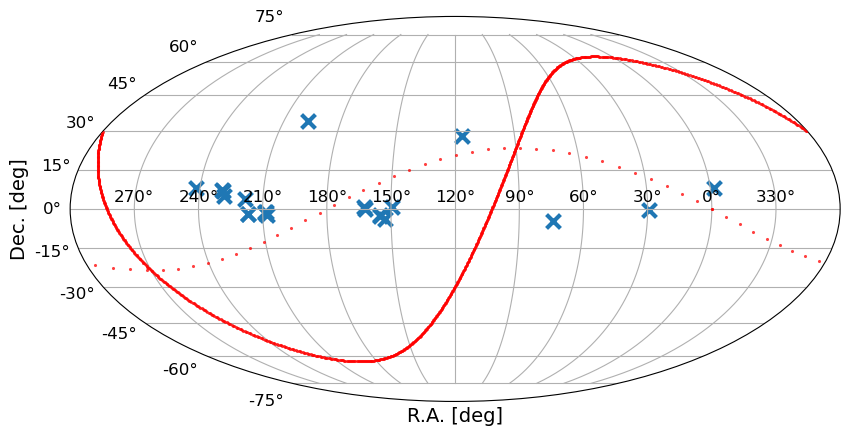

In [28]:
ax = init_sky()

ax.scatter(ax.projection_ra(sne_coords.ra.value), 
           ax.projection_dec(sne_coords.dec.value), 
           marker='x', 
           s=100,
           linewidth=3,
           color='tab:blue')

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../../Figures/Y1/iron_0pt_sky.png', dpi=150, facecolor='none');

### Compute the Absolute Magnitude of the 0-pt Calibrators based on the Distance

Compute the absolute magnitude
$$
M_r - 5\log{h} = m_r - \mu - 5\log{h},
$$
where $h$ is the reduced Hubble constant used to calibrate the distance modulus $\mu$.

Since our calibrators are from Pantheon+SH0ES, where distances are based on the distance ladder, there is no assumed value of $h$.

In [29]:
#- Clean up the distance modulus
use_primary = zeroptab['MU_SECONDARY'] < 0
mu = zeroptab['MU_SECONDARY']
mu[use_primary] = zeroptab['MU_PRIMARY'][use_primary]
# mu = zeroptab['MU_PRIMARY']

#- Compute the absolute magnitude
zeroptab['R_ABSMAG_SB26'] = zeroptab['R_MAG_SB26_CORR'] - mu
zeroptab['R_ABSMAG_SB26_err'] = np.sqrt(zeroptab['R_MAG_SB26_ERR_CORR']**2 + zeroptab['MU_ERR']**2)

In [30]:
# Save this table
zeroptab.write('SGA-2020_iron_Vrot_VI_0pt_calib_z0p1.fits', overwrite=True)

# Access Cluster Catalog

These clusters come from the group catalog used by Kourkchi et al. in [*CosmicFlows-4: The Calibration of Optical and Infrared Tully-Fisher Relations*](https://iopscience.iop.org/article/10.3847/1538-4357/ab901c), ApJ 896:3, 2020.

Cluster membership is defined as
1. $R_p < 1.5R_{2t}$ AND $v < V_c \pm 3\sigma_p$, OR
1. $1.5R_{2t} \leq R_p < 3R_{2t}$ AND $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the center of the cluster, $R_{2t}$ is the projected cluster second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [31]:
clusters = Table.read('../Tully15-Table3.fits')
clusters[:5]

<Table length=5>
f_Nest  Nest   Nmb    PGC1   SGLON   ...  sigV    R2t    sigP     Mlum      CF  
                              deg    ... km / s   Mpc   km / s    Msun          
int16  int32  int16  int32  float64  ... int16  float64 int16   float64  float64
------ ------ ----- ------- -------- ... ------ ------- ------ --------- -------
     1 100001   136   44715  89.6226 ...    886   2.129   1045 1.710e+15    1.65
     1 100002   197   41220 103.0008 ...    670   1.440    707 5.290e+14    1.00
     1 100003   113   43296 156.2336 ...    822   1.520    746 6.230e+14    1.12
     1 100004    81   58265  71.5103 ...    740   2.153   1057 1.770e+15    2.26
     1 100005    61   36487  92.0255 ...    707   1.560    766 6.730e+14    1.58

# Find Cluster Membership

Identify SGA galaxies in the list of galaxy groups from Tully (2015).

Loop through the data and keep only clusters where DESI has at least 20 galaxies with TF measurements passing all quality cuts.

In [32]:
#- Sky coordinates of SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]
print(len(sgatab_sel))

sga_coords = SkyCoord(sgatab_sel['RA'], sgatab_sel['DEC'], unit='deg')
z_sga_desi = sgatab_sel['Z_DESI']

5733


In [33]:
sga_clusters = {}
m_dwarf_clusters = {}
n_cluster_min = 15

# for cluster in tqdm(clusters[['Nest', 'SGLON', 'SGLAT', 'R2t', 'sigP', 'DM']]):
for i in tqdm(range(len(clusters))):
    nest_id = clusters['Nest'][i]
    
    #- Sky coordinates of cluster
    cls_coord = SkyCoord(clusters['SGLON'][i], 
                         clusters['SGLAT'][i], 
                         unit='deg', 
                         frame='supergalactic')

    #- Cluster turnaround radius, velocity dispersion, and distance modulus
    R2t = clusters['R2t'][i]
    sigP = clusters['sigP'][i]
    mu = clusters['DM'][i]

    #- Convert distance moduli to velocities [in km/s]
    dist = 10 * 10**(0.2*mu)
    velo = 100 * (dist*1e-6) # Tully used H0 = 100 km/s/Mpc, which is why we are using 100 here and not H0 

    #- Apply cuts on angular separation
    sep = cls_coord.separation(sga_coords)
    R2t_angle_1p5 = np.arctan(1.5*R2t / (velo/H0)) * u.radian
    R2t_angle_3 = np.arctan(3*R2t / (velo/H0)) * u.radian

    #- Apply cluster cuts.
    in_cluster_1 = (sep < R2t_angle_1p5) & (z_sga_desi*c_kms > velo - 3*sigP) & (z_sga_desi*c_kms < velo + 3*sigP)
    in_cluster_2 = (sep >= R2t_angle_1p5) & (sep < R2t_angle_3) & (z_sga_desi*c_kms > velo - 2*sigP) & (z_sga_desi*c_kms < velo + 2*sigP)
    in_cluster = in_cluster_1 | in_cluster_2

    if np.any(in_cluster) and np.sum(in_cluster) >= n_cluster_min:
        if nest_id in sga_clusters:
            warnings.warn(f'Cluster ID {nest_id} already encountered.', RuntimeWarning)
        sga_clusters[nest_id] = list(sgatab_sel['SGA_ID'][in_cluster])
        m_dwarf_clusters[nest_id] = -17 + mu

100%|██████████| 25474/25474 [03:23<00:00, 125.43it/s]


In [34]:
for i, (cluster_id, sga_ids) in enumerate(sga_clusters.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies')

 1  100007  15 galaxies
 2  100067  28 galaxies
 3  100077  15 galaxies
 4  100221  21 galaxies
 5  100282  23 galaxies
 6  101400  26 galaxies
 7  101434  18 galaxies
 8  101788  25 galaxies
 9  101823  16 galaxies
10  103172  16 galaxies
11  103175  15 galaxies
12  103182  28 galaxies
13  103203  19 galaxies
14  103206  21 galaxies
15  103229  24 galaxies


## Sanity Checks: Plot Cluster Positions and Galaxy Coordinates

[False False False ... False False False]


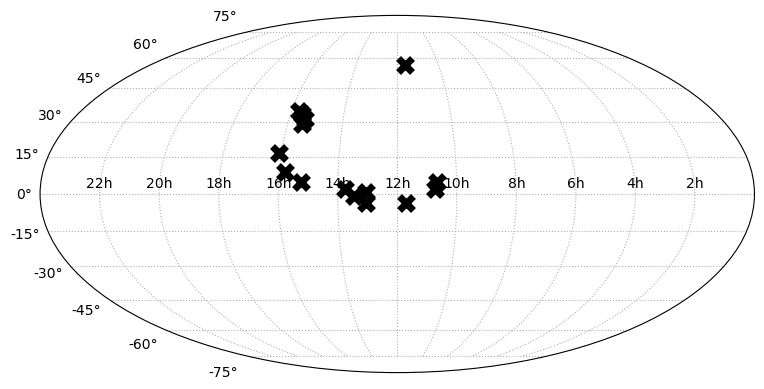

In [35]:
nest_ids = np.asarray(list(sga_clusters.keys()))
idx = np.in1d(clusters['Nest'], nest_ids)
print(idx)
cluster_lon = clusters['SGLON'][idx]
cluster_lat = clusters['SGLAT'][idx]
cluster_coords = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
for coord in cluster_coords:
    _ra = np.radians(180*u.deg - coord.transform_to('icrs').ra)
    _dec = np.radians(coord.transform_to('icrs').dec)
    ax.plot(_ra, _dec, 'kx', ms=10, mew=5)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');
# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_clusters_20241203.png', dpi=150);

In [36]:
def geometric_median(X, eps=1e-6):
    """Compute the weighted geometric median of a set of points using Weiszfeld's algorithm.

    From https://github.com/scoutant/l1-median. Weiszfeld's algorithm may fail to converge
    if a guess is located on top of one of the initial points. If that occurs, move the guess.
    
    A summary of other algorithms is provided in
    https://www.cs.cmu.edu/~./glmiller/Publications/Papers/CLMPS16.pdf.

    Parameters
    ----------
    X : ndarray
        list of sample points (n-D), given as a 2D array
    eps : float
        Tolerance for convergence to the median.

    Returns
    -------
    y : ndarray
        First n-D estimate of the median satisfying the tolerance.
    """
    #- See with the geometric mean
    y = np.mean(X,0)
    while True:
        #- Compute Euclidean distances. Move away to avoid any null distances.
        while np.any(cdist(X,[y])==0):
            y +=0.1*np.ones(len(y))
            
        #- Weights that are the inverse of the distances from current estimate to the observations
        W = 1/cdist(X,[y]) # element-wise
        
        #- Update is the weighted average of the observations
        y1 = np.sum(W*X,0)/np.sum(W) # sum along axis 0
        if euclidean(y,y1) < eps:
            return y1
        y = y1

def cluster_median_coords(galaxy_coords):
    """Compute the geometric median coordinate of the galaxies in a cluster.

    Parameters
    ----------
    galaxy_coords : ndarray
        List of SkyCoords for galaxies in a cluster or group.

    Returns
    -------
    gal_median : SkyCoord
        Coordinates of the geometric median.
    """
    #- Pack the clusters coordinates into an array of Cartesian coordinates
    galcoords = []
    for galaxy in galaxy_coords:
        galcoords.append(galaxy.represent_as('cartesian').get_xyz())
    galcoords = np.asarray(galcoords)

    #- Compute the geometric median.
    gm = geometric_median(galcoords)
    lonlat = SkyCoord(x=gm[0], y=gm[1], z=gm[2], representation_type='cartesian').transform_to('icrs').represent_as('unitspherical')
    gal_median = SkyCoord(ra=lonlat.lon.deg, dec=lonlat.lat.deg, unit='degree', frame='icrs')

    return gal_median

In [37]:
def plot_cluster_members(clusters, cluster_id, sgacat, sga_ids):
    """Generate a set of diagnostic plots for the members of a cluster.
    """
    
    #- Get cluster sky coordinates
    idx = np.in1d(clusters['Nest'], cluster_id)
    cluster_lon = clusters['SGLON'][idx][0]
    cluster_lat = clusters['SGLAT'][idx][0]
    cluster_mu = clusters['DM'][idx][0]
    cluster_dist = 10 * 10**(0.2*cluster_mu) * 1e-6
    cluster_v = H0*cluster_dist
    cluster_sigma = clusters['sigP'][idx][0]
    cluster_R2t = clusters['R2t'][idx][0]
    cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_3 = np.arctan(3*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_4 = np.arctan(4*cluster_R2t / (cluster_v/H0)) * u.radian
    
    cluster_coord = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic').transform_to('icrs')

    print(cluster_coord)
    print(f'{cluster_v} +/- {cluster_sigma} km/s')

    #- Get SGA galaxy coordinates and median of observations
    idx = np.in1d(sgacat['SGA_ID'], sga_ids)
    z_sga = sgacat['Z_DESI'][idx]
    z_sorted = np.sort(z_sga)
    ngal = len(z_sorted)
    z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
    sga_coords = SkyCoord(ra=sgacat['RA'][idx], dec=sgacat['DEC'][idx], unit='deg', frame='icrs')
    sga_coords_median = cluster_median_coords(sga_coords)

    #- Plot the angular coordinates and redshifts
    fig = plt.figure(figsize=(12,8), tight_layout=True)
    ax = plt.subplot(231, projection='astro degrees zoom', center=cluster_coord, radius=cluster_R2t_4)
    ax.grid()

    ax.plot(sga_coords.ra.deg, sga_coords.dec.deg, 'o', transform=ax.get_transform('world'), alpha=0.5, label=f'{cluster_id}')
    ax.plot(sga_coords_median.ra.deg, sga_coords_median.dec.deg, 'rD', transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster_coord.ra.deg, cluster_coord.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)

    inner = SphericalCircle(cluster_coord, cluster_R2t_1p5, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='dotted', facecolor='none')
    ax.add_patch(inner)

    outer = SphericalCircle(cluster_coord, cluster_R2t_3, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
    ax.add_patch(outer)
    
    ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]')

    #- Plot the Dec vs redshift and velocity limits
    ax = plt.subplot(232)
    ax.plot(z_sga, sga_coords.dec.deg, 'o', alpha=0.5, label=f'{cluster_id}')
    ax.plot(z_sga_median, sga_coords_median.dec.deg, 'rD', ms=5, mew=5)
    ax.plot(cluster_v/c_kms, cluster_coord.dec.deg, 'kx', ms=10, mew=5)

    decmin = np.min(sga_coords.dec.deg) - 0.5
    decmax = np.max(sga_coords.dec.deg) + 0.5

    ax.vlines(np.asarray([cluster_v-3*cluster_sigma,
                          cluster_v+3*cluster_sigma,
                          cluster_v-2*cluster_sigma,
                          cluster_v+2*cluster_sigma])/c_kms,
              decmin, decmax,
              colors='tab:blue',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(xlabel='redshift',
           ylabel=r'$\delta$ [deg]',
           ylim=(decmin, decmax))

    #- Plot the RA vs redshift and velocity limits
    ax = plt.subplot(233)
    ax.plot(sga_coords.ra.deg, z_sga, 'o', alpha=0.5, label=f'{cluster_id}')
    ax.plot(sga_coords_median.ra.deg, z_sga_median, 'rD', ms=5, mew=5)
    ax.plot(cluster_coord.ra.deg, cluster_v/c_kms, 'kx', ms=10, mew=5)

    ramin = np.min(sga_coords.ra.deg) - 0.5
    ramax = np.max(sga_coords.ra.deg) + 0.5

    ax.hlines(np.asarray([cluster_v-3*cluster_sigma,
                          cluster_v+3*cluster_sigma,
                          cluster_v-2*cluster_sigma,
                          cluster_v+2*cluster_sigma])/c_kms,
              ramin, ramax,
              colors='tab:blue',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(ylabel='redshift',
           xlabel=r'$\alpha$ [deg]',
           xlim=(ramax, ramin))

    #- Histograms of RA, Dec, and redshift:
    delta_angle = 0.75
    
    ax = plt.subplot(234)
    ax.hist(sga_coords.ra.deg, bins=np.arange(ramin, ramax+delta_angle, delta_angle))
    ax.vlines(sga_coords_median.ra.deg, 0, 50, colors='r', linestyles='dotted')
    ax.vlines(cluster_coord.ra.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\alpha$ [deg]',
           xlim=(ramax+delta_angle, ramin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    ax = plt.subplot(235)
    ax.hist(sga_coords.dec.deg, bins=np.arange(decmin, decmax+delta_angle, delta_angle))
    ax.vlines(sga_coords_median.dec.deg, 0, 50, colors='r', linestyles='dotted')
    ax.vlines(cluster_coord.dec.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\delta$ [deg]',
           xlim=(decmax+delta_angle, decmin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    dz = 0.0025
    zmin = np.min(np.round(z_sga, 2)) - 4*dz
    zmax = np.max(np.round(z_sga, 2)) + 4*dz

    ax = plt.subplot(236)
    ax.hist(z_sga, bins=np.arange(zmin, zmax + dz, dz))
    ax.vlines(z_sga_median, 0, 50, colors='r', linestyles='dotted')
    ax.vlines(cluster_v/c_kms, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel='redshift',
           xlim=(zmin, zmax),
           ylabel='count',
           ylim=(0,10))

    fig.suptitle(f'TF Iron Observations of Tully Group {cluster_id}')

    return fig

<SkyCoord (ICRS): (ra, dec) in deg
    (241.05808519, 16.95441739)>
11587.773561551261 +/- 1385 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (228.80657754, 4.74840124)>
11587.773561551261 +/- 954 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (174.18925473, 56.12464342)>
18281.002161427445 +/- 1914 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (175.41038787, -3.83222093)>
17782.794100389227 +/- 1273 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (232.05444778, 29.03388829)>
20892.961308540405 +/- 2071 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (160.81499432, 1.91346557)>
22387.211385683422 +/- 1711 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (233.44768796, 33.24483532)>
20701.413487910413 +/- 1196 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (195.7953898, 0.67439744)>
21877.616239495565 +/- 1599 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (159.82603928, 4.85617483)>
21978.598727848275 +/- 1636 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (237.23262377, 8.84560326)>
23014.418174085138 +/- 1823 km

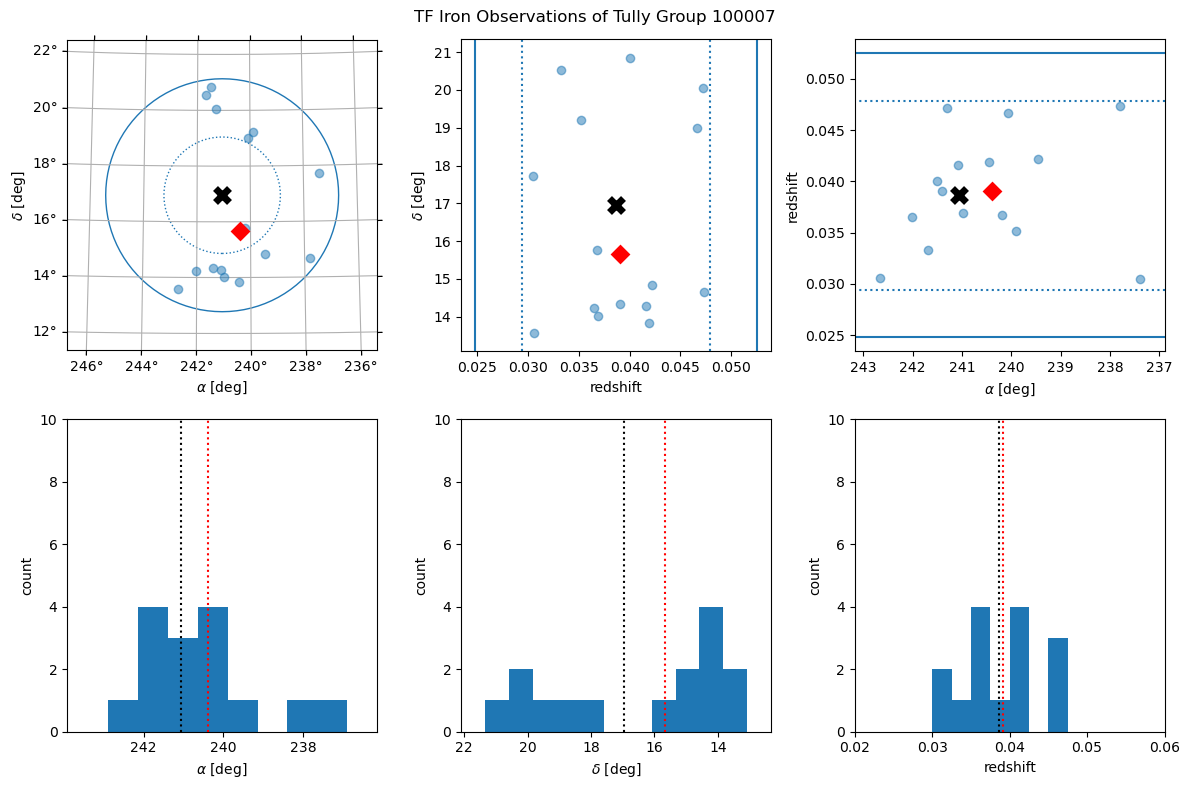

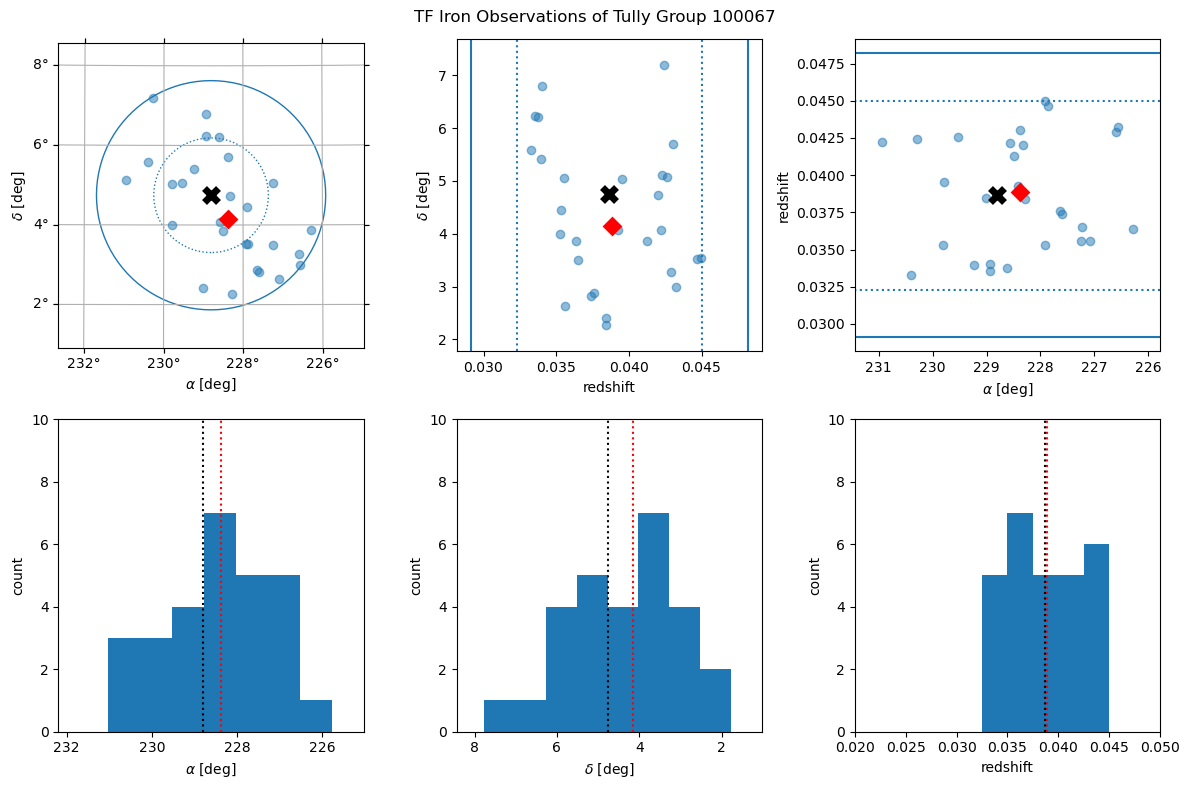

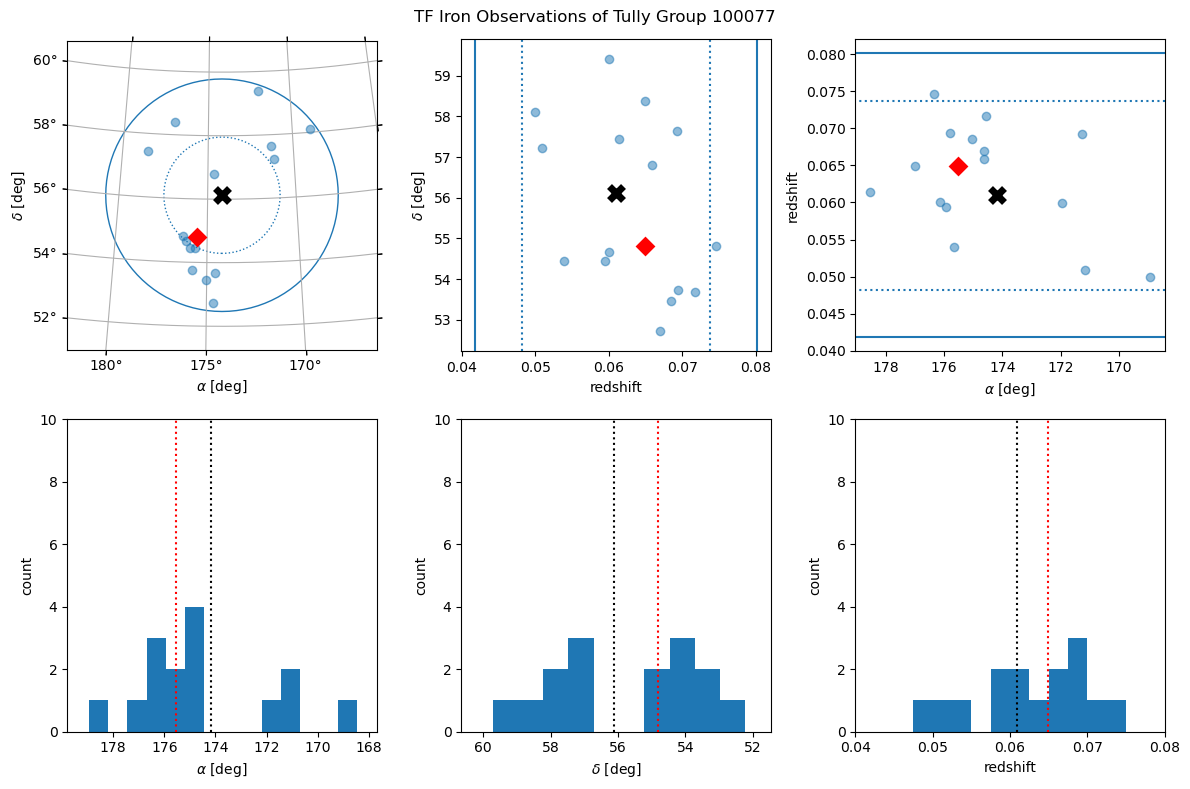

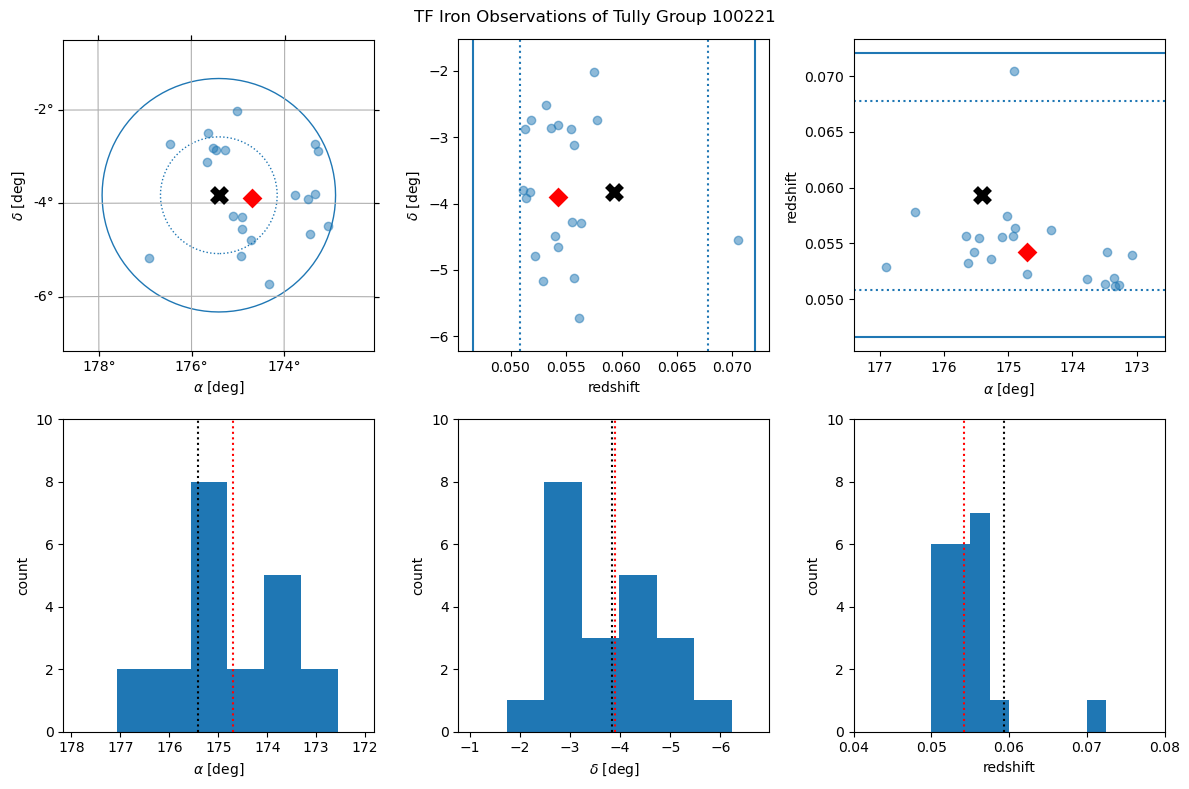

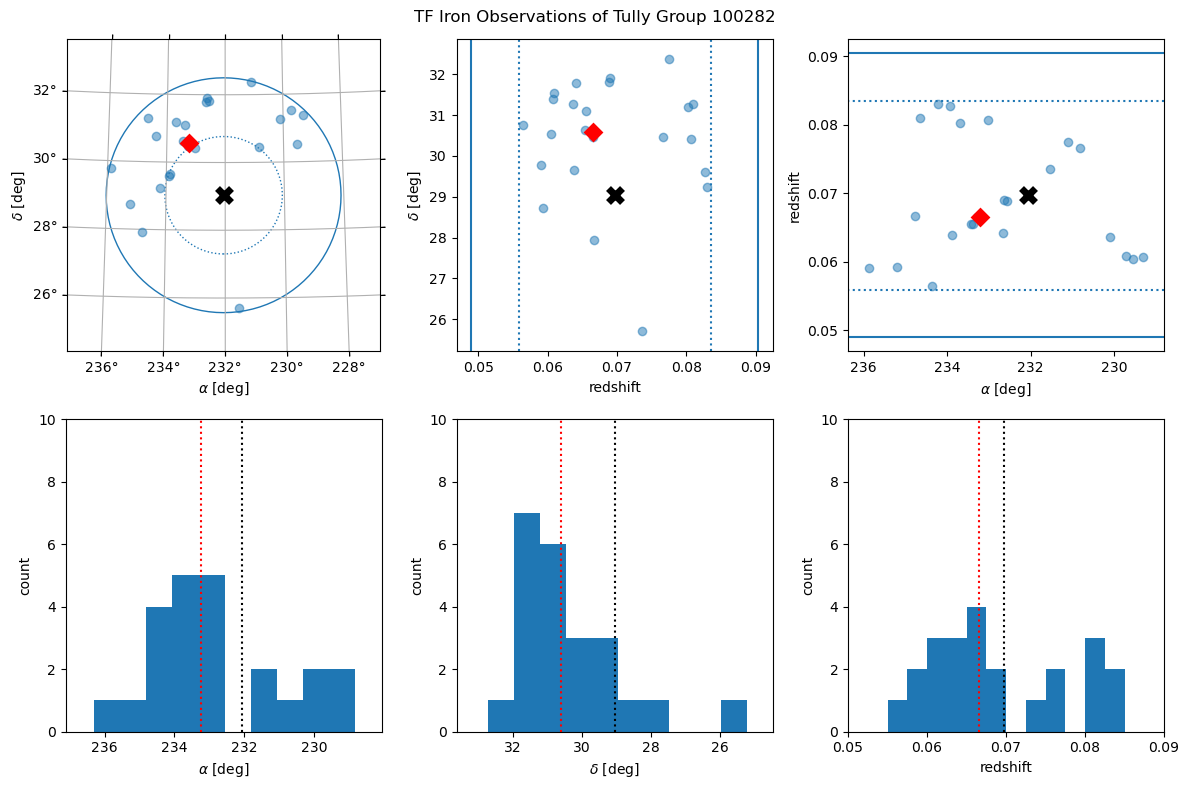

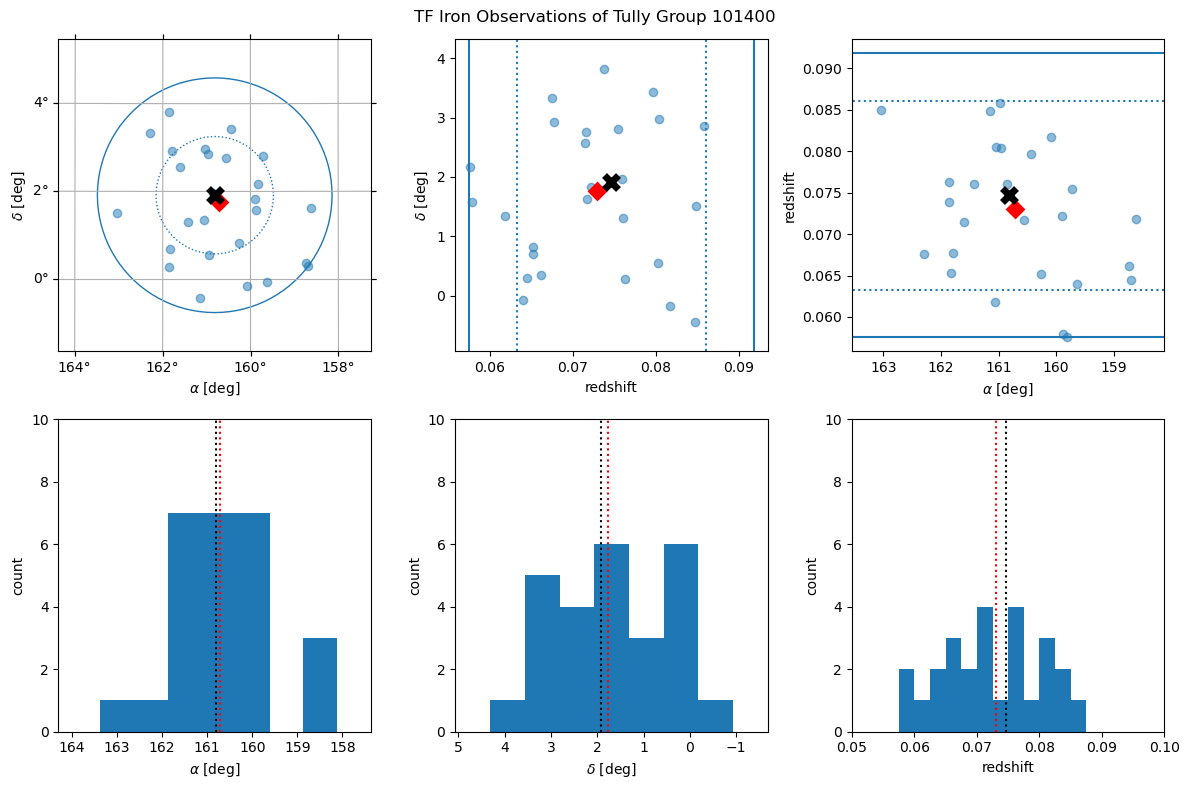

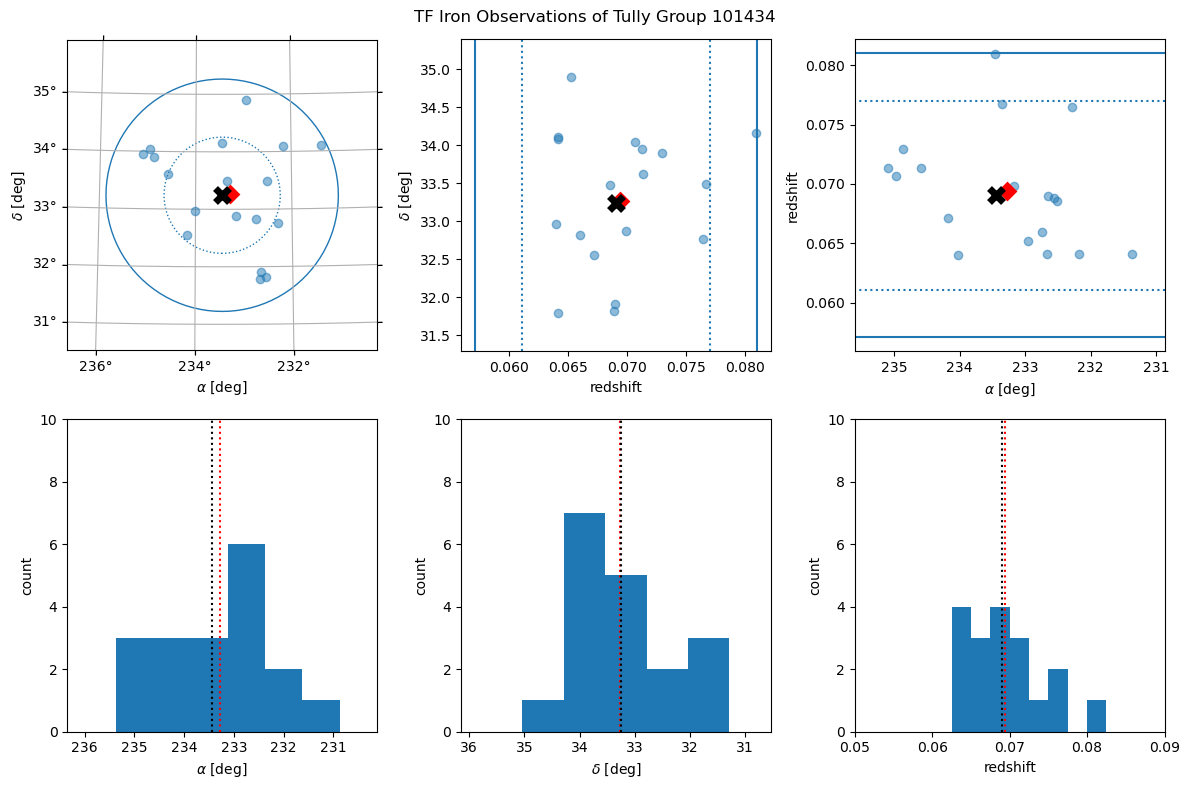

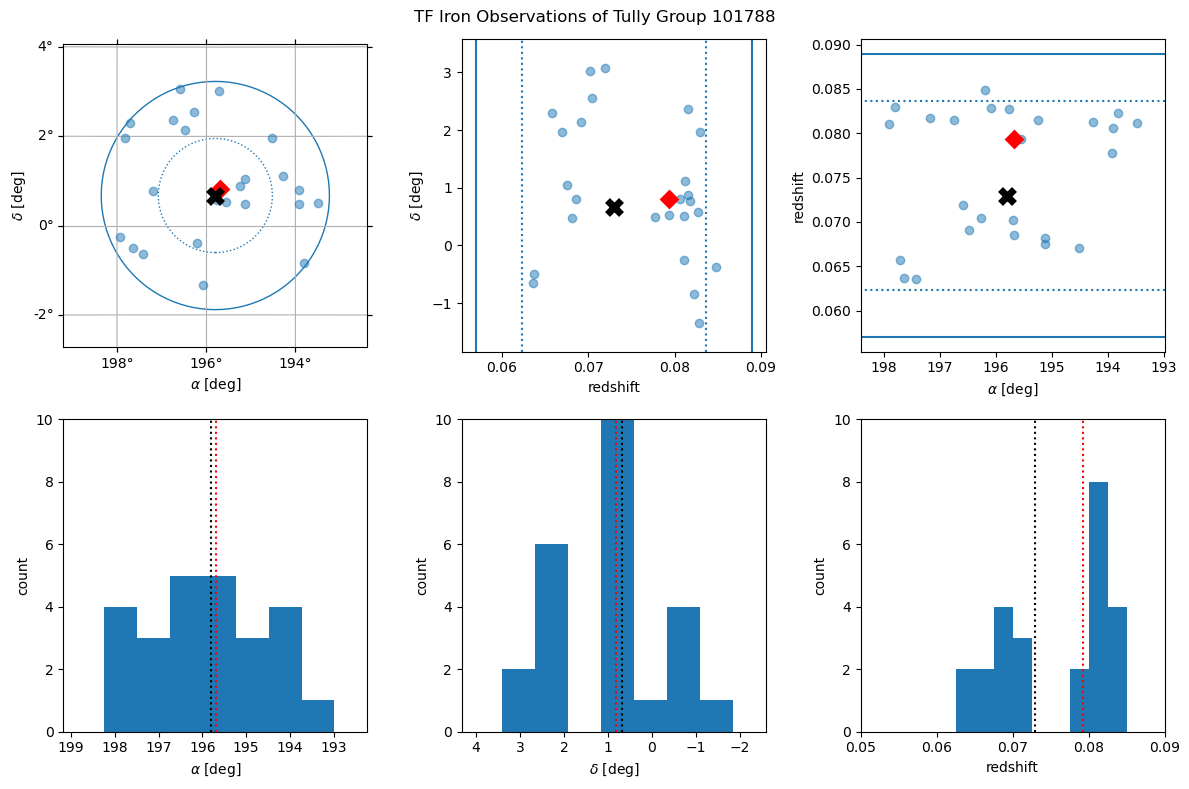

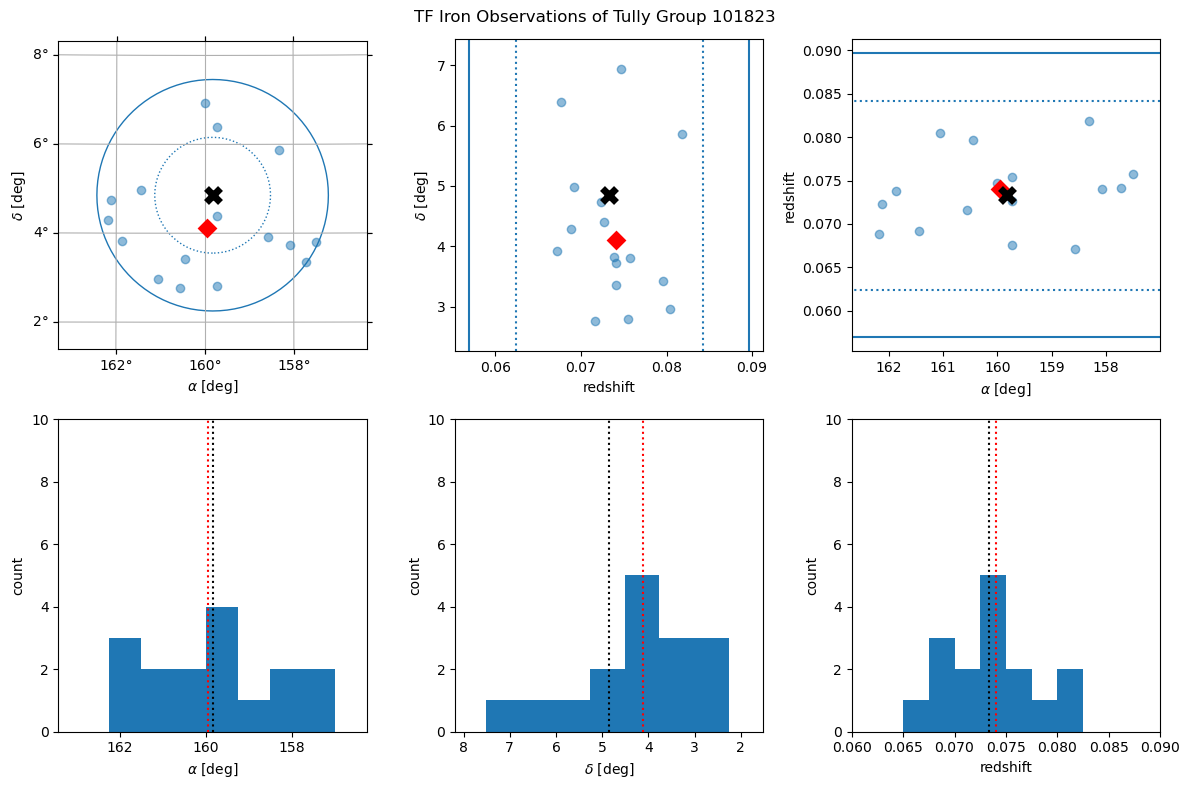

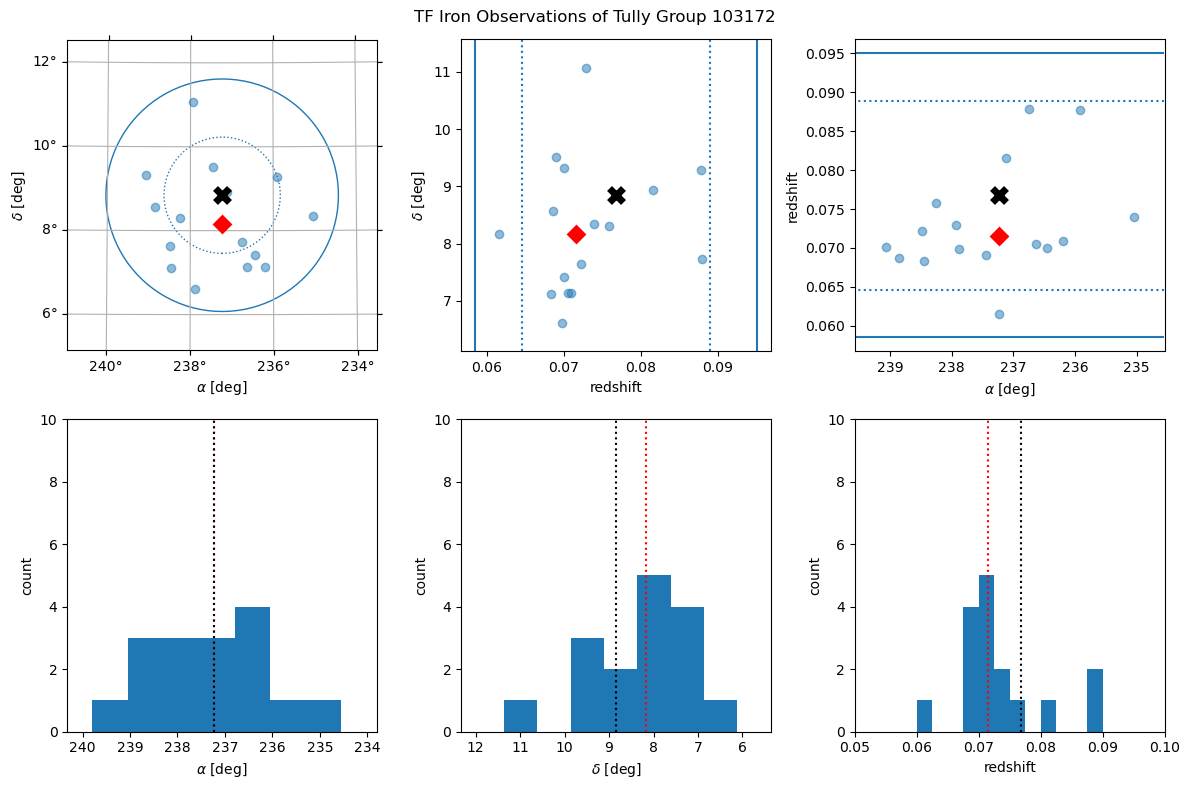

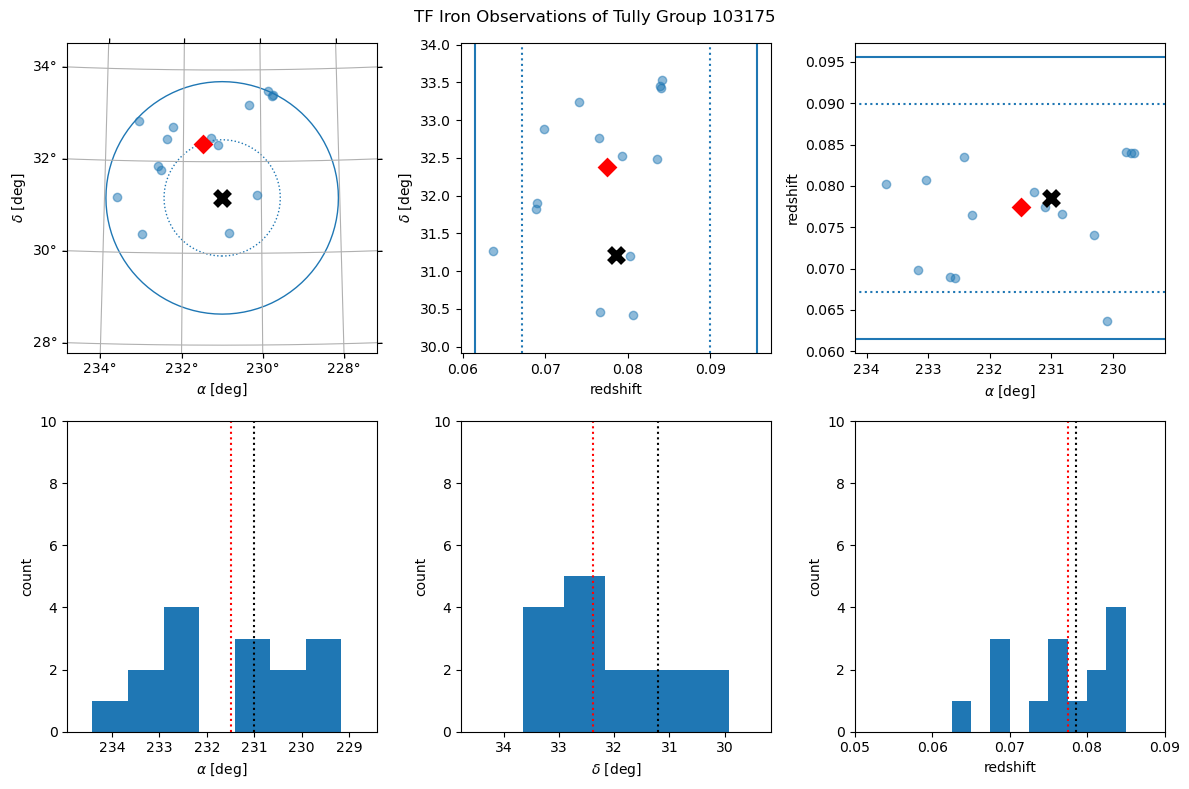

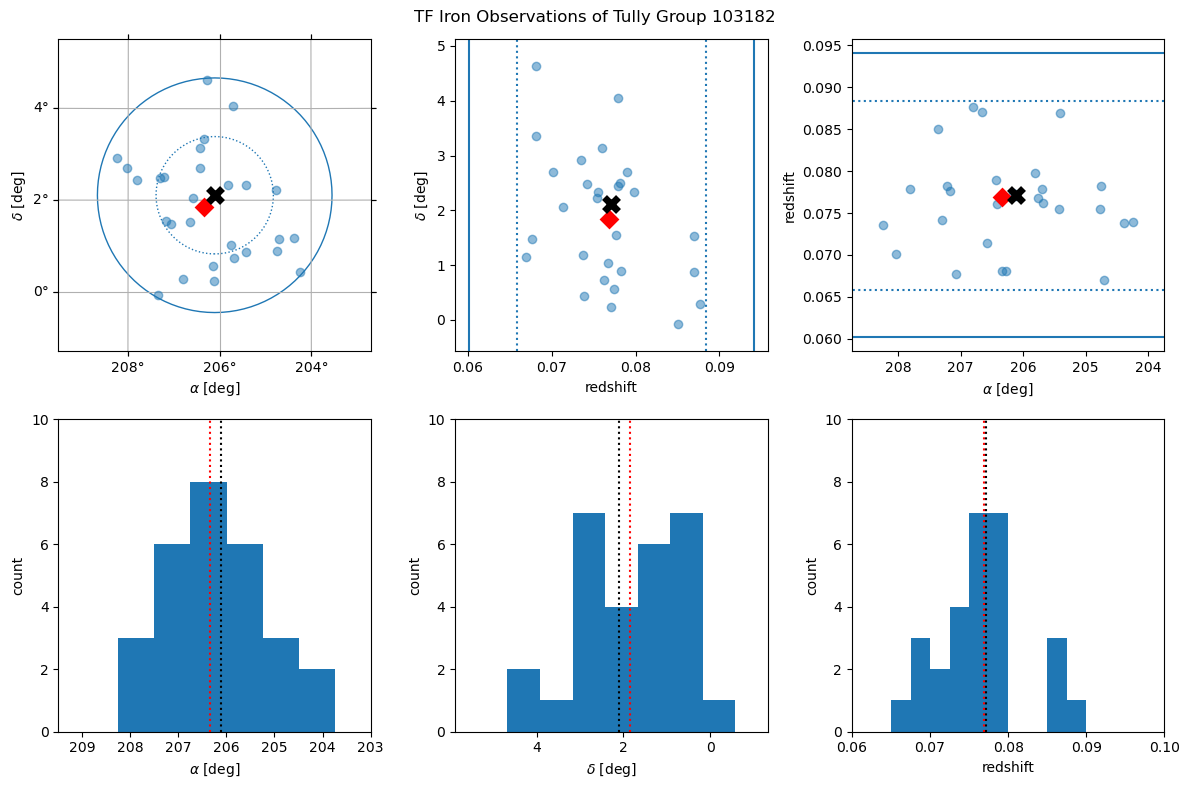

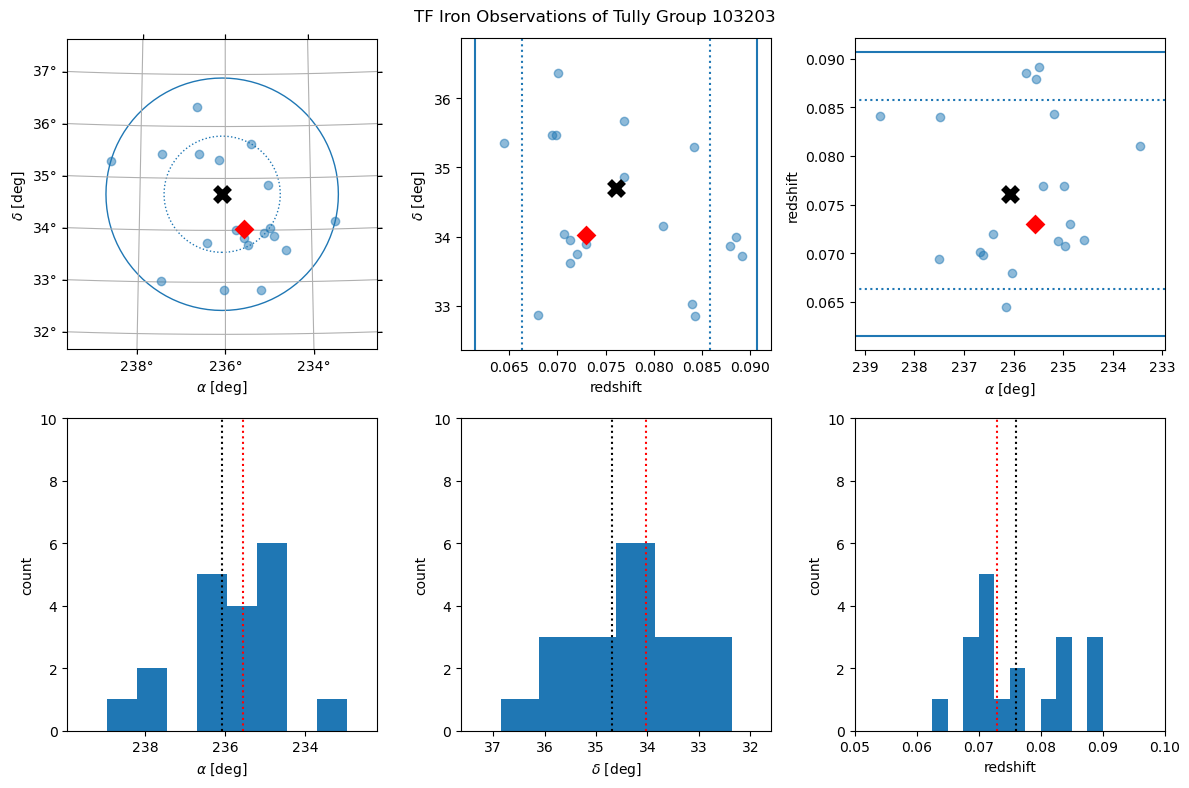

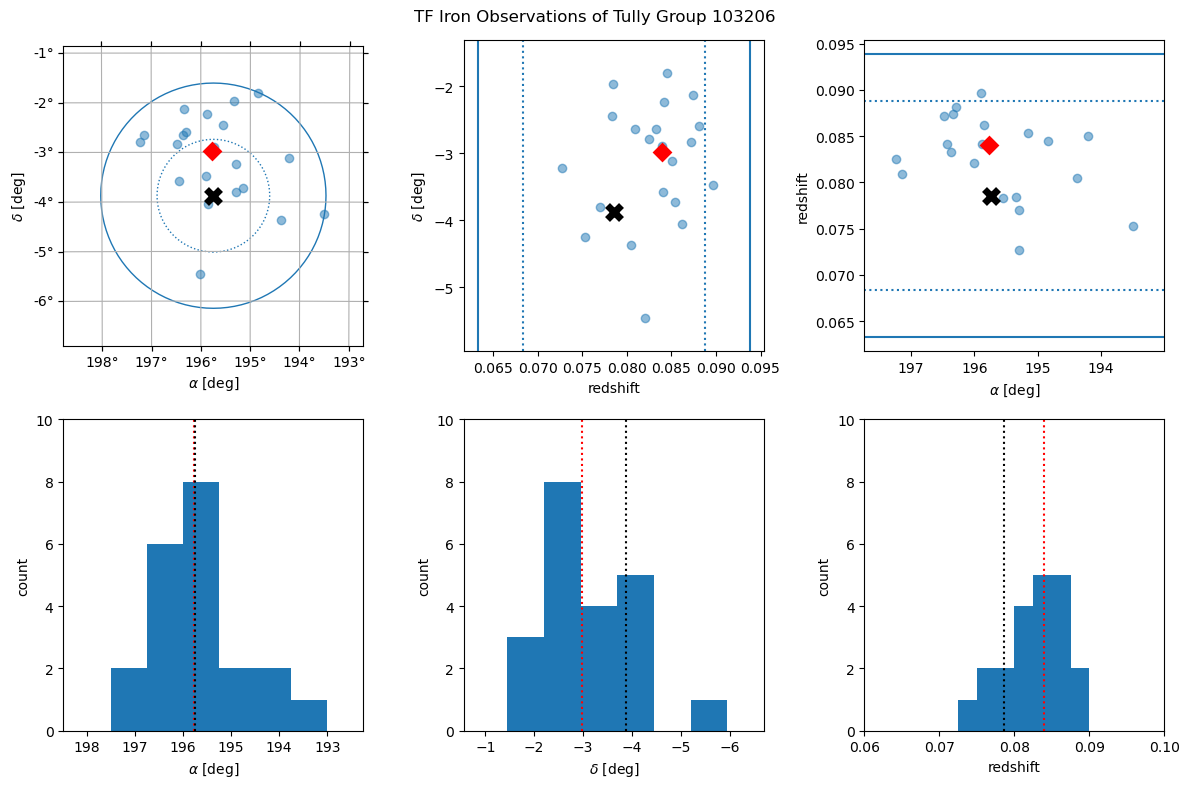

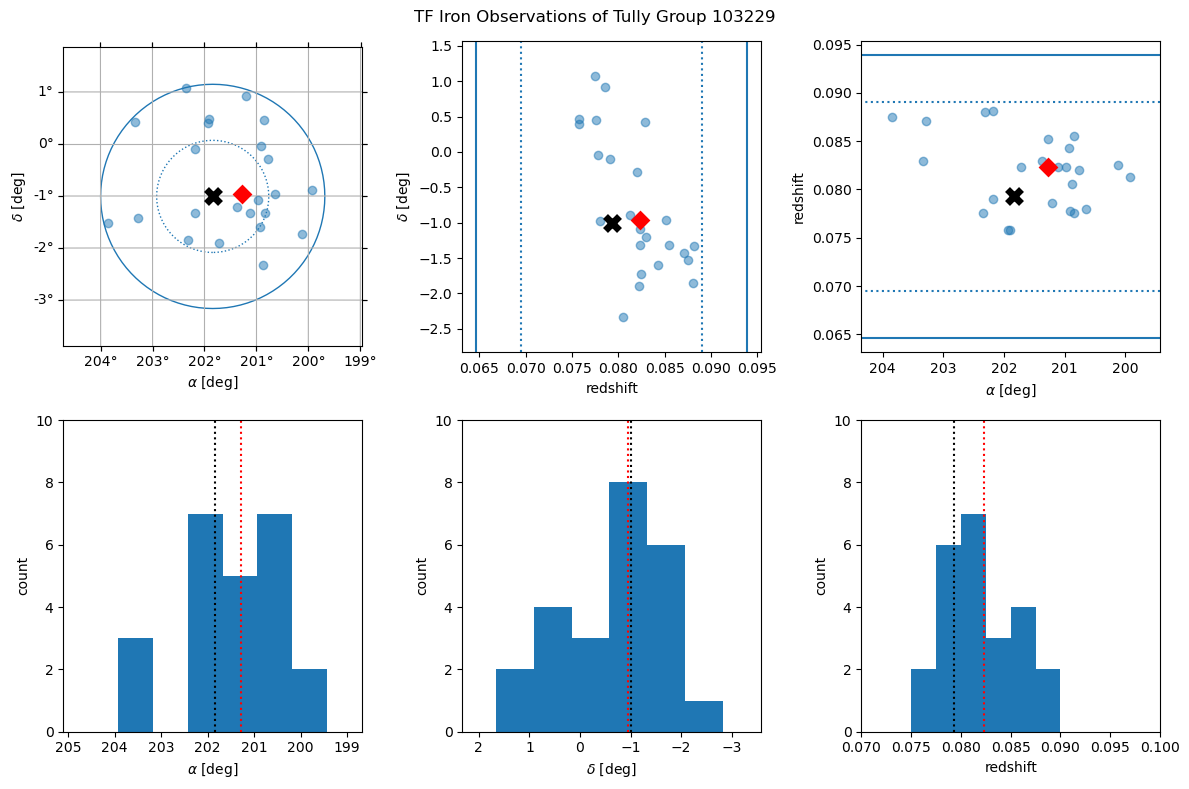

In [38]:
for cluster_id in sga_clusters.keys():
    fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])

# Apply Cluster Selection

Plot the clusters as a function of $\Delta\theta/\angle(R_{2t})$ versus $\Delta v/\sigma_P$. The quantities are:
* $\Delta\theta$: the angular separation between the median position of the DESI observations and the cluster center reported in Tully 2015.
* $\angle(R_{2t})$: the angular projection of the cluster second turnaround radius.
* $\Delta v = v_\text{cluster} - v_\text{SGA,median}$.
* $\sigma_P$: the velocity dispersion of the cluster, reported in Tully 2015.

A reasonable selection appears to be

1. $\Delta v/ \sigma_P < 1$
2. $\Delta\theta / R_{2t} < 1$

100007       133.601 km/s    1385.000 km/s       0.096       1.447 deg       1.395 deg       0.692
100067        56.157 km/s     954.000 km/s       0.059       0.741 deg       0.961 deg       0.515
100077      1186.487 km/s    1914.000 km/s       0.620       1.524 deg       1.222 deg       0.832
100221      1519.091 km/s    1273.000 km/s       1.193       0.710 deg       0.835 deg       0.566
100282       931.258 km/s    2071.000 km/s       0.450       1.851 deg       1.156 deg       1.067
101400       505.807 km/s    1711.000 km/s       0.296       0.183 deg       0.892 deg       0.137
101434       113.067 km/s    1196.000 km/s       0.095       0.139 deg       0.674 deg       0.138
101788      1899.372 km/s    1599.000 km/s       1.188       0.181 deg       0.853 deg       0.141
101823       227.677 km/s    1636.000 km/s       0.139       0.755 deg       0.869 deg       0.579
103172      1567.969 km/s    1823.000 km/s       0.860       0.675 deg       0.924 deg       0.487
103175    

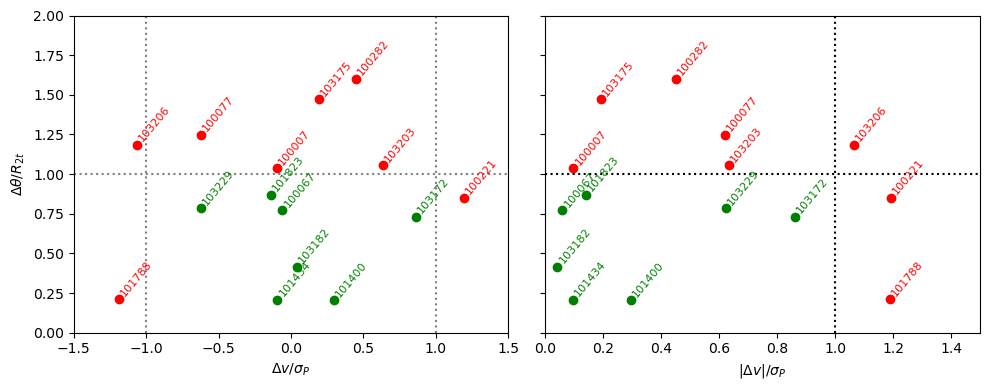

In [39]:
keep_cluster = []
dv_sigmaP = []
dtheta_R2t = []
cluster_ids = []

for cluster_id, sga_ids in sga_clusters.items():
    #- Get cluster sky coordinates
    idx = np.in1d(clusters['Nest'], cluster_id)
    cluster_lon = clusters['SGLON'][idx][0]
    cluster_lat = clusters['SGLAT'][idx][0]
    cluster_mu = clusters['DM'][idx][0]
    cluster_dist = 10 * 10**(0.2*cluster_mu) * 1e-6
    cluster_v = H0*cluster_dist
    cluster_sigma = clusters['sigP'][idx][0]
    cluster_R2t = clusters['R2t'][idx][0]
    cluster_R2t_angle = np.arctan(cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_3 = np.arctan(3*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_4 = np.arctan(4*cluster_R2t / (cluster_v/H0)) * u.radian
    
    cluster_coord = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic').transform_to('icrs')
    
    #- Get SGA galaxy coordinates and median of observations
    idx = np.in1d(sgatab['SGA_ID'], sga_ids)
    z_sga = sgatab['Z_DESI'][idx]
    z_sorted = np.sort(z_sga)
    ngal = len(z_sorted)
    z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
    sga_coords = SkyCoord(ra=sgatab['RA'][idx], dec=sgatab['DEC'][idx], unit='deg', frame='icrs')
    sga_coords_median = cluster_median_coords(sga_coords)

    #- Compute the angle and velocity ratios:
    delta_v = cluster_v - c_kms*z_sga_median
    _dv_sigP = delta_v / cluster_sigma
    dv_sigmaP.append(_dv_sigP)

    delta_theta = sga_coords_median.separation(cluster_coord).to('rad')
    _dth_R2t = delta_theta / cluster_R2t_angle
    dtheta_R2t.append(_dth_R2t)

    cluster_ids.append(cluster_id)

    #- Print results:
    print(f'{cluster_id:<8d}{np.abs(delta_v):12.3f} km/s{cluster_sigma:12.3f} km/s{np.abs(delta_v)/cluster_sigma:12.3f}' \
          f'{delta_theta.to("deg"):12.3f}{cluster_R2t_angle.to("deg"):12.3f}{delta_theta / (1.5*cluster_R2t_angle):12.3f}')

dv_sigmaP = np.asarray(dv_sigmaP)
dtheta_R2t = np.asarray(dtheta_R2t)
cluster_ids = np.asarray(cluster_ids)

#- Apply selection
dvcut = 1
dthcut = 1
select = (np.abs(dv_sigmaP) < dvcut) & (dtheta_R2t < dthcut)

#- Plot results

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True, tight_layout=True)
ax = axes[0]
ax.scatter(dv_sigmaP[select], dtheta_R2t[select], color='g')
for _dv, _dth, _id in zip(dv_sigmaP[select], dtheta_R2t[select], cluster_ids[select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

ax.scatter(dv_sigmaP[~select], dtheta_R2t[~select], color='r')
for _dv, _dth, _id in zip(dv_sigmaP[~select], dtheta_R2t[~select], cluster_ids[~select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

ax.axvline(dvcut, ls=':', color='k', alpha=0.5)
ax.axvline(-dvcut, ls=':', color='k', alpha=0.5)
ax.axhline(dthcut, ls=':', color='k', alpha=0.5)
ax.set(xlabel=r'$\Delta v/\sigma_P$',
       xlim=(-1.5, 1.5),
       ylabel=r'$\Delta\theta/R_{2t}$',
       ylim=(0,2))

ax = axes[1]
ax.scatter(np.abs(dv_sigmaP[select]), dtheta_R2t[select], color='g')
for _dv, _dth, _id in zip(np.abs(dv_sigmaP[select]), dtheta_R2t[select], cluster_ids[select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

ax.scatter(np.abs(dv_sigmaP[~select]), dtheta_R2t[~select], color='r')
for _dv, _dth, _id in zip(np.abs(dv_sigmaP[~select]), dtheta_R2t[~select], cluster_ids[~select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

ax.axvline(dvcut, ls=':', color='k')
ax.axvline(-dvcut, ls=':', color='k')
ax.axhline(dthcut, ls=':', color='k')
ax.set(xlabel=r'$|\Delta v|/\sigma_P$',
       xlim=(0, 1.5));

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_clusters_selection_binaryMLupdated_20241023.png', dpi=150);

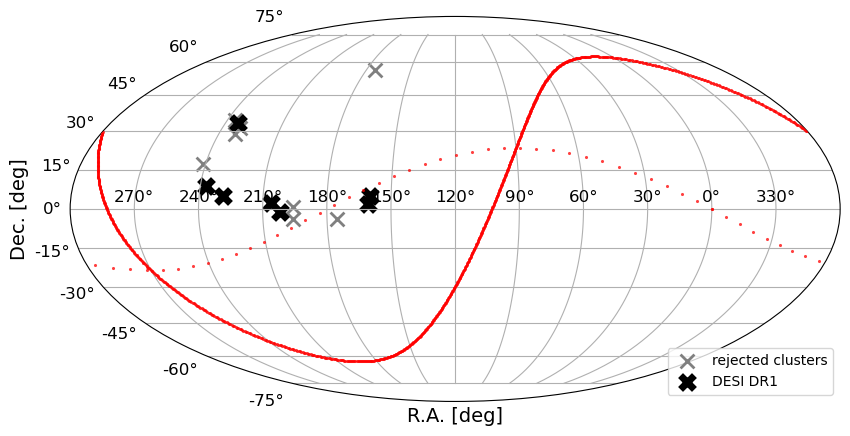

In [40]:
nest_ids = np.asarray(list(sga_clusters.keys()))
good_idx = np.in1d(clusters['Nest'], nest_ids[select])
bad_idx = np.in1d(clusters['Nest'], nest_ids[~select])
good_cluster_coords = SkyCoord(clusters['SGLON'][good_idx], clusters['SGLAT'][good_idx], unit='deg', frame='supergalactic')
bad_cluster_coords = SkyCoord(clusters['SGLON'][bad_idx], clusters['SGLAT'][bad_idx], unit='deg', frame='supergalactic')

ax = init_sky()

ax.scatter(ax.projection_ra(bad_cluster_coords.transform_to('icrs').ra.value), 
           ax.projection_dec(bad_cluster_coords.transform_to('icrs').dec.value), 
           marker='x', 
           s=100,
           linewidth=2,
           color='gray', 
           label='rejected clusters')
ax.scatter(ax.projection_ra(good_cluster_coords.transform_to('icrs').ra.value), 
           ax.projection_dec(good_cluster_coords.transform_to('icrs').dec.value), 
           marker='x', 
           s=100,
           linewidth=5,
           color='black', 
           label='DESI DR1')

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.legend(loc='lower right')

plt.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../Figures/Y1/iron_clusters_sky.png', dpi=150, facecolor='none');

In [41]:
for i, (cluster_id, sga_ids) in enumerate(sga_clusters.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies  {"Y" if select[i] else "N"}')

 1  100007  15 galaxies  N
 2  100067  28 galaxies  Y
 3  100077  15 galaxies  N
 4  100221  21 galaxies  N
 5  100282  23 galaxies  N
 6  101400  26 galaxies  Y
 7  101434  18 galaxies  Y
 8  101788  25 galaxies  N
 9  101823  16 galaxies  Y
10  103172  16 galaxies  Y
11  103175  15 galaxies  N
12  103182  28 galaxies  Y
13  103203  19 galaxies  N
14  103206  21 galaxies  N
15  103229  24 galaxies  Y


## Plot Galaxy Clusters that Failed the Selection

<SkyCoord (ICRS): (ra, dec) in deg
    (241.05808519, 16.95441739)>
11587.773561551261 +/- 1385 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (174.18925473, 56.12464342)>
18281.002161427445 +/- 1914 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (175.41038787, -3.83222093)>
17782.794100389227 +/- 1273 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (232.05444778, 29.03388829)>
20892.961308540405 +/- 2071 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (195.7953898, 0.67439744)>
21877.616239495565 +/- 1599 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (230.99936671, 31.21107645)>
23550.492838960086 +/- 1707 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (236.07424061, 34.69623742)>
22803.420720004207 +/- 1458 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (195.74616921, -3.87530193)>
23550.492838960086 +/- 1529 km/s


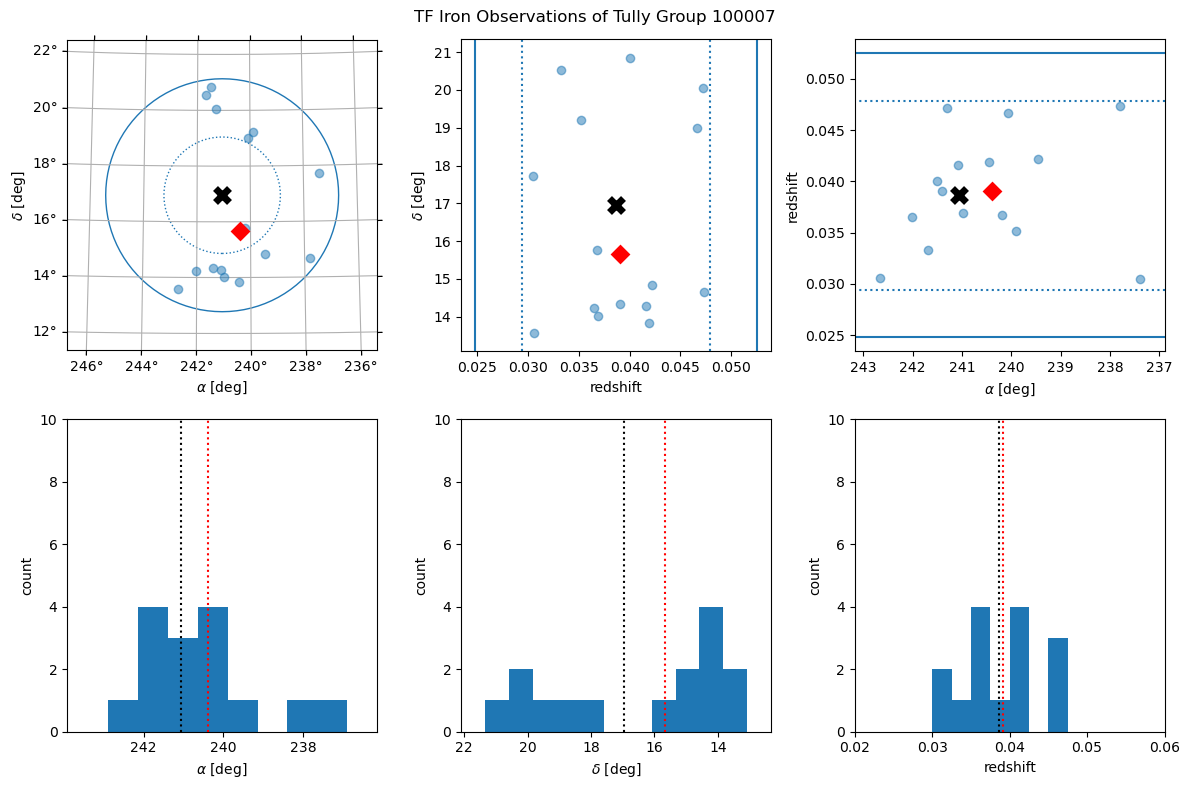

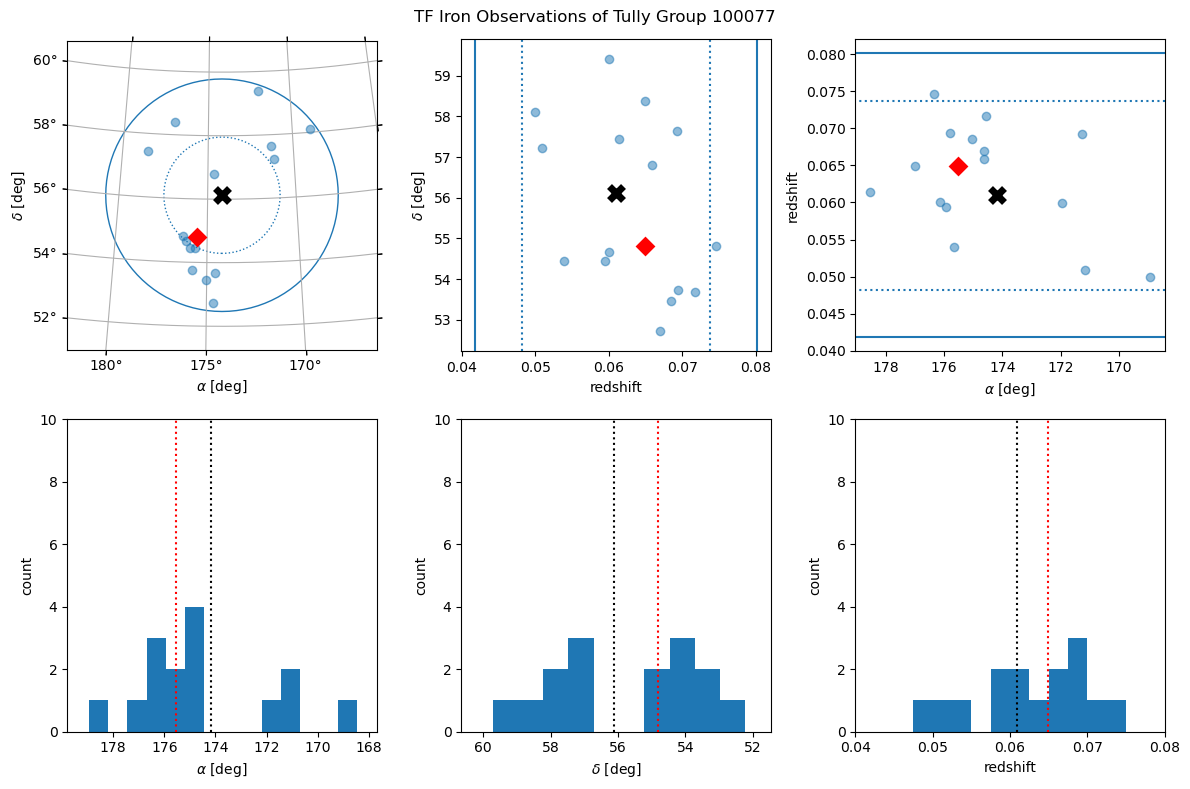

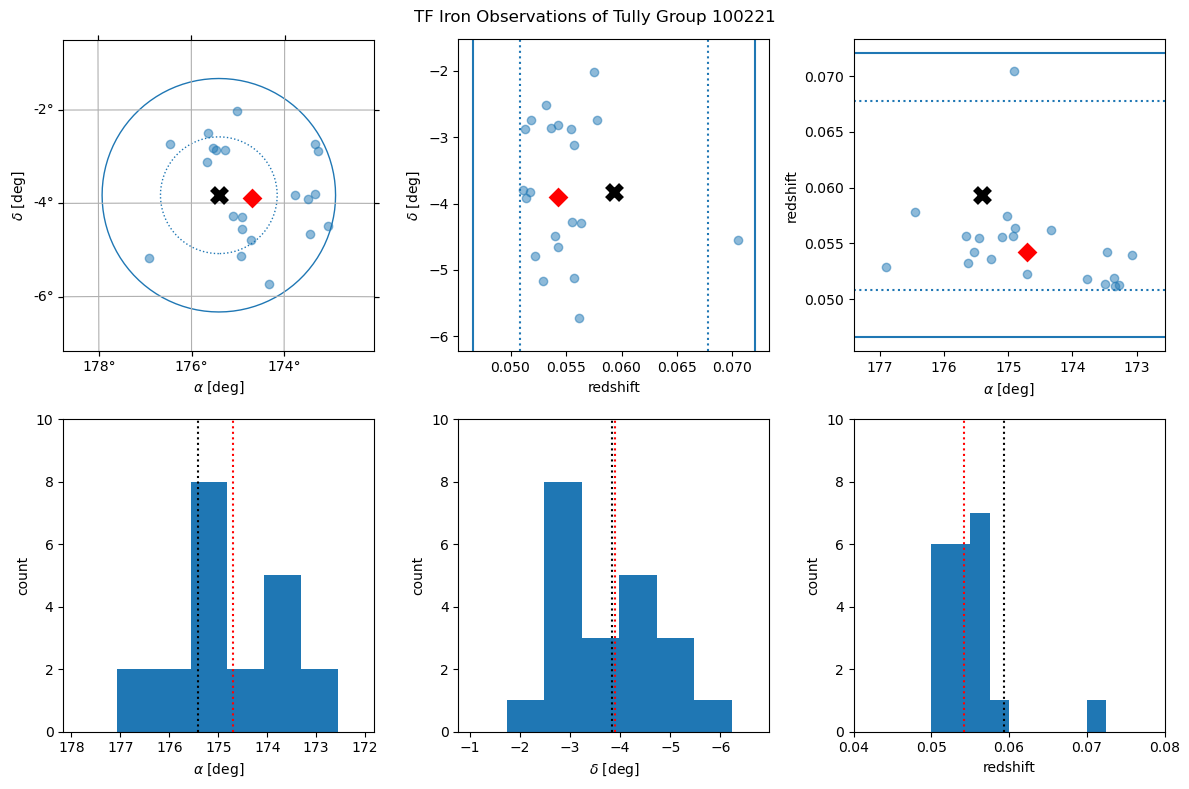

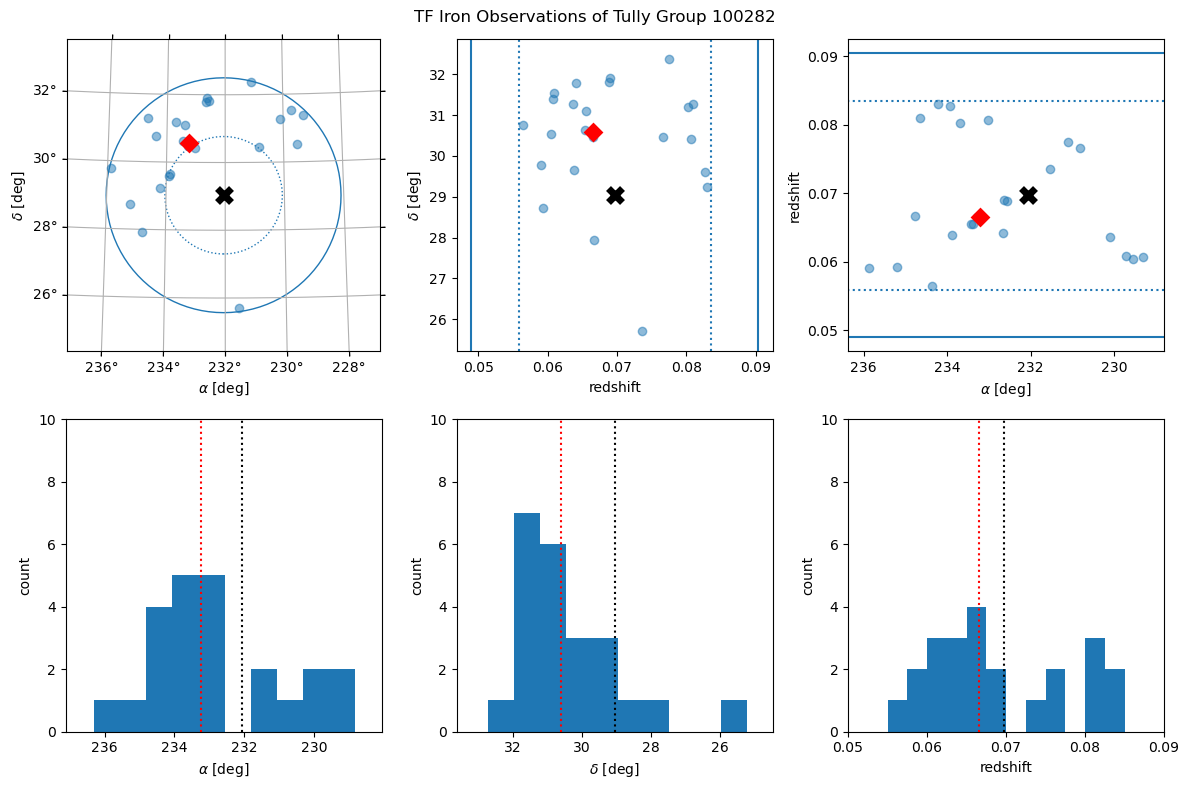

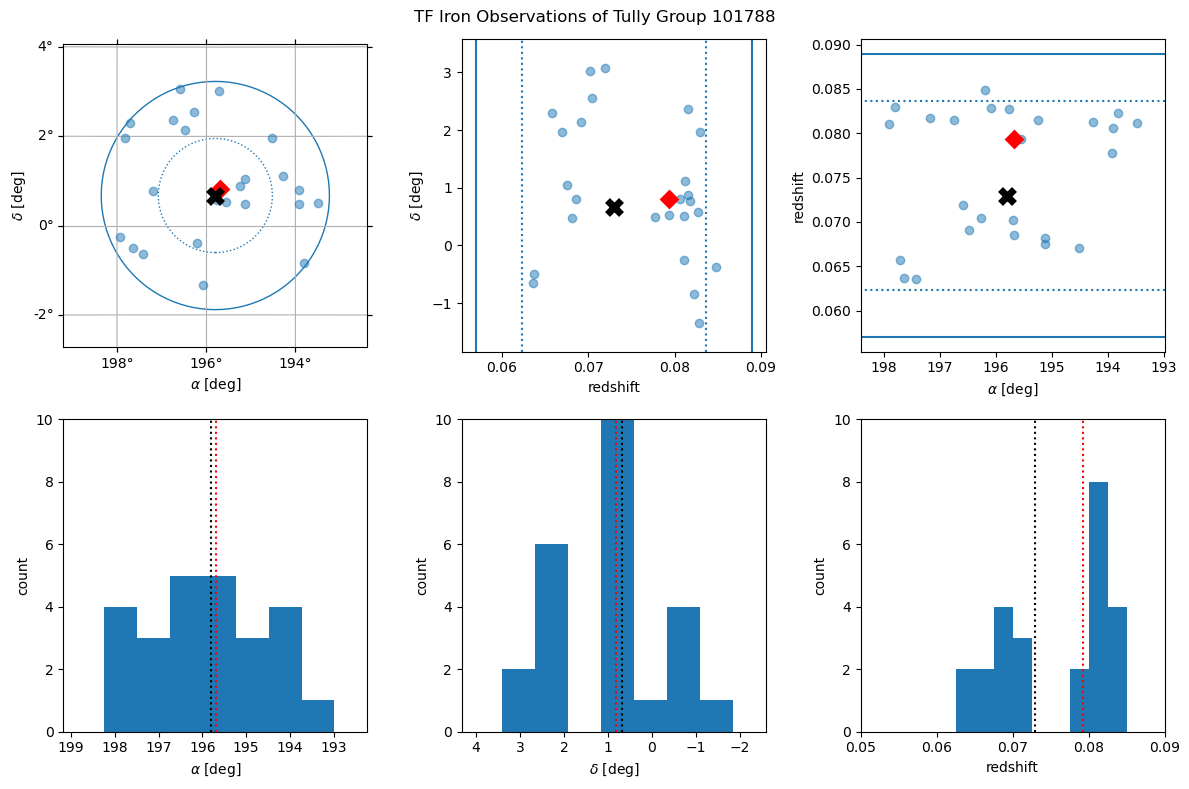

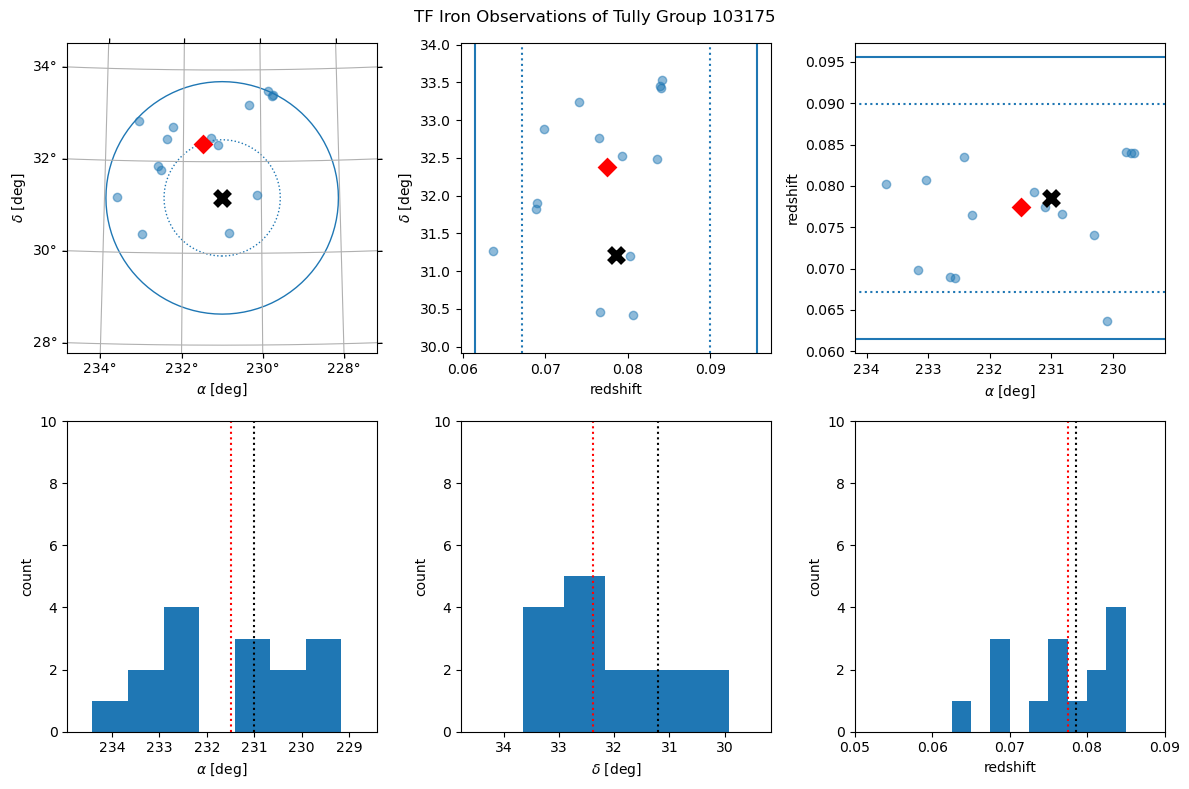

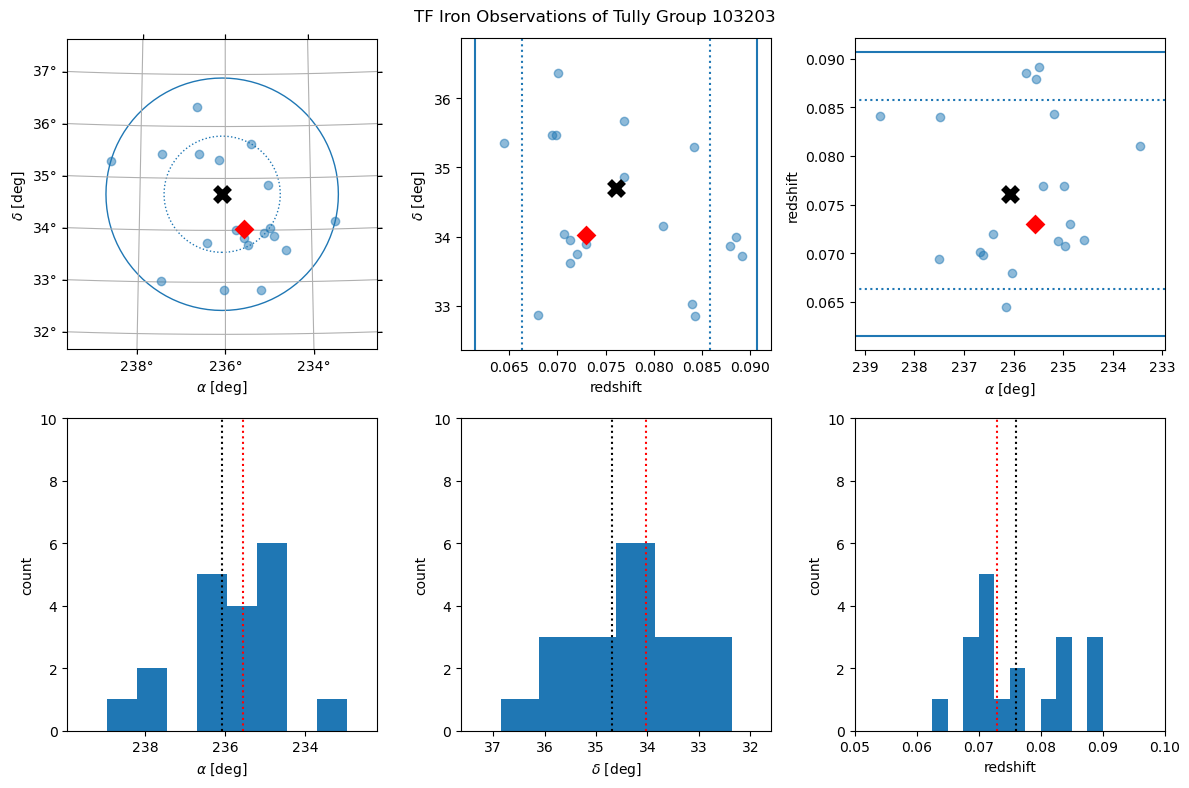

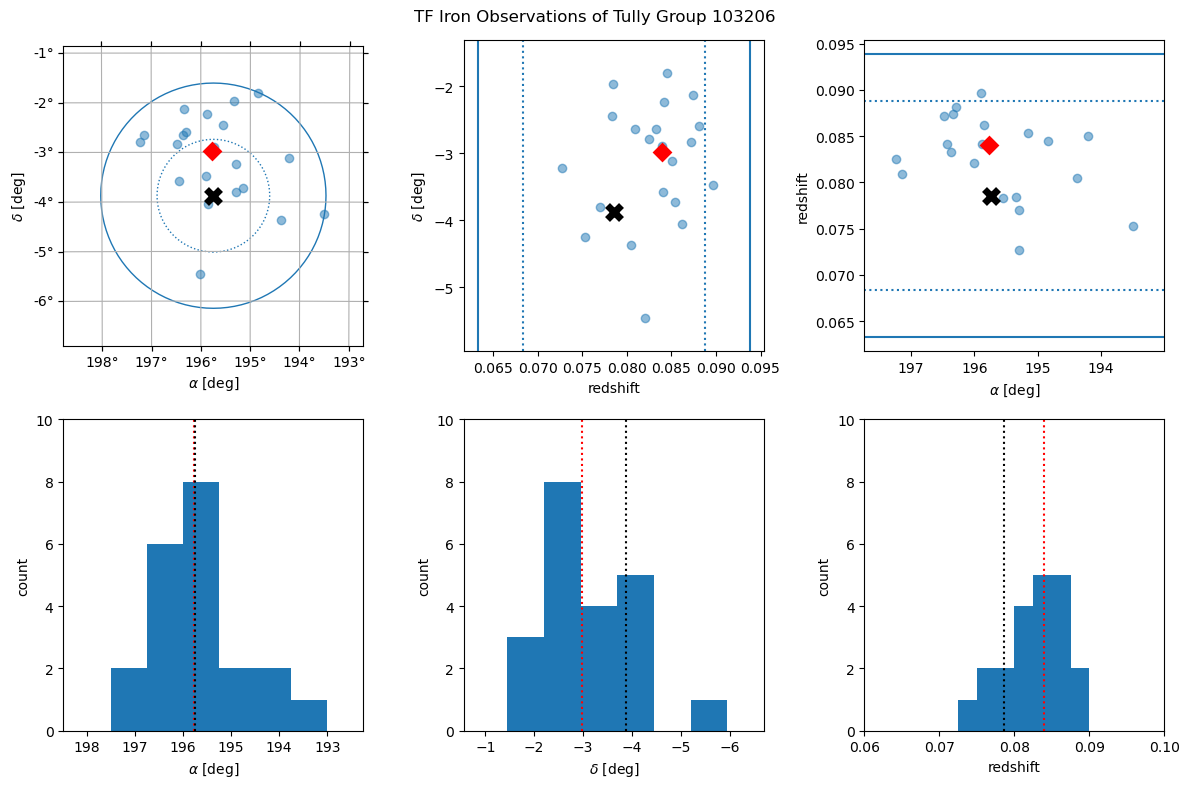

In [42]:
for cluster_id in sga_clusters.keys():
    if cluster_id in cluster_ids[~select]:
        fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])
        # fig.savefig(f'../../Figures/Y1/TF_Y1_cluster_{cluster_id}_reject.png', dpi=150);

## Plot Galaxy Clusters that Passed the Selection

<SkyCoord (ICRS): (ra, dec) in deg
    (228.80657754, 4.74840124)>
11587.773561551261 +/- 954 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (160.81499432, 1.91346557)>
22387.211385683422 +/- 1711 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (233.44768796, 33.24483532)>
20701.413487910413 +/- 1196 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (159.82603928, 4.85617483)>
21978.598727848275 +/- 1636 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (237.23262377, 8.84560326)>
23014.418174085138 +/- 1823 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (206.10730715, 2.1097726)>
23120.647901755987 +/- 1693 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (201.84149945, -1.00863004)>
23768.402866248827 +/- 1465 km/s


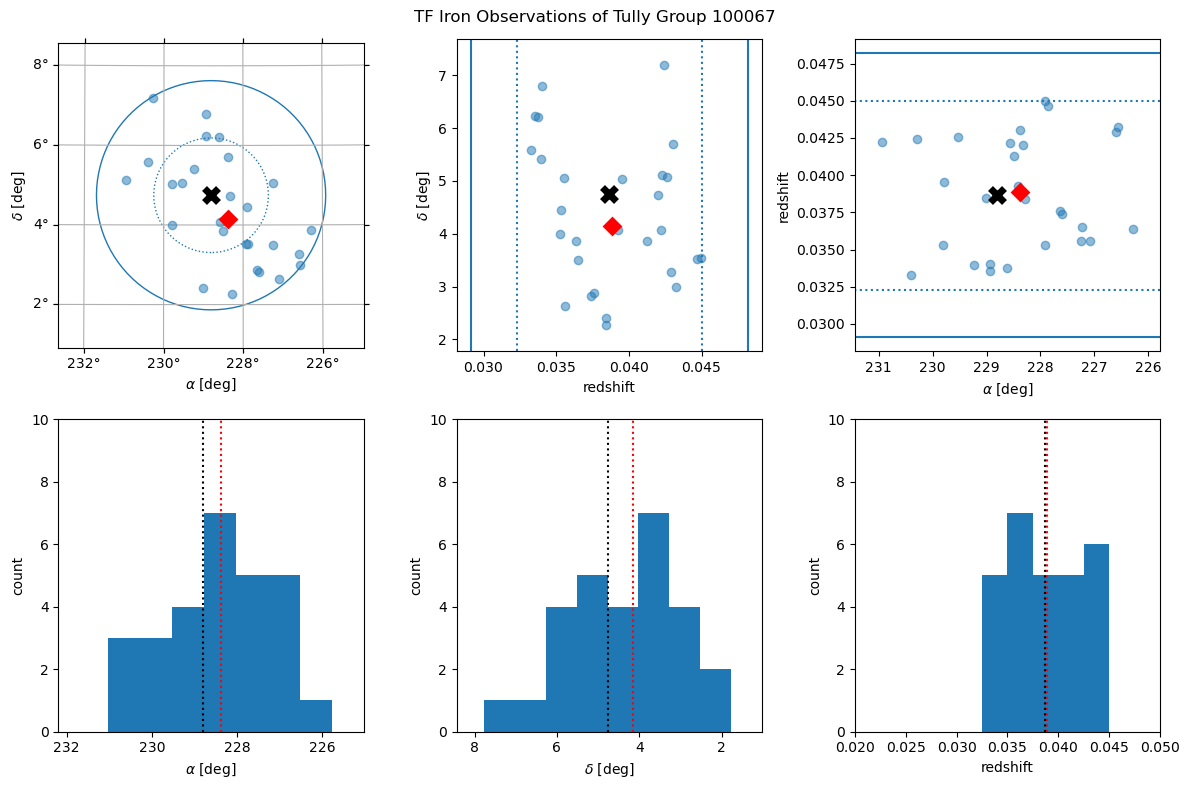

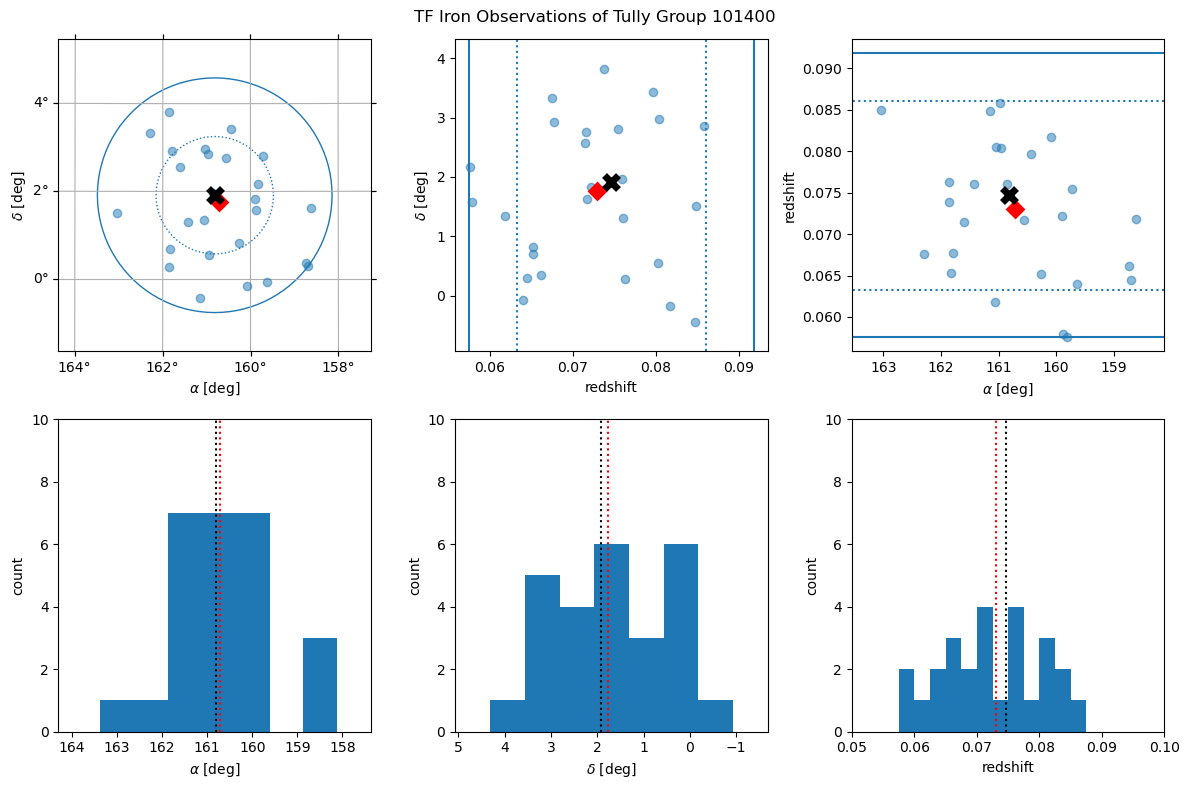

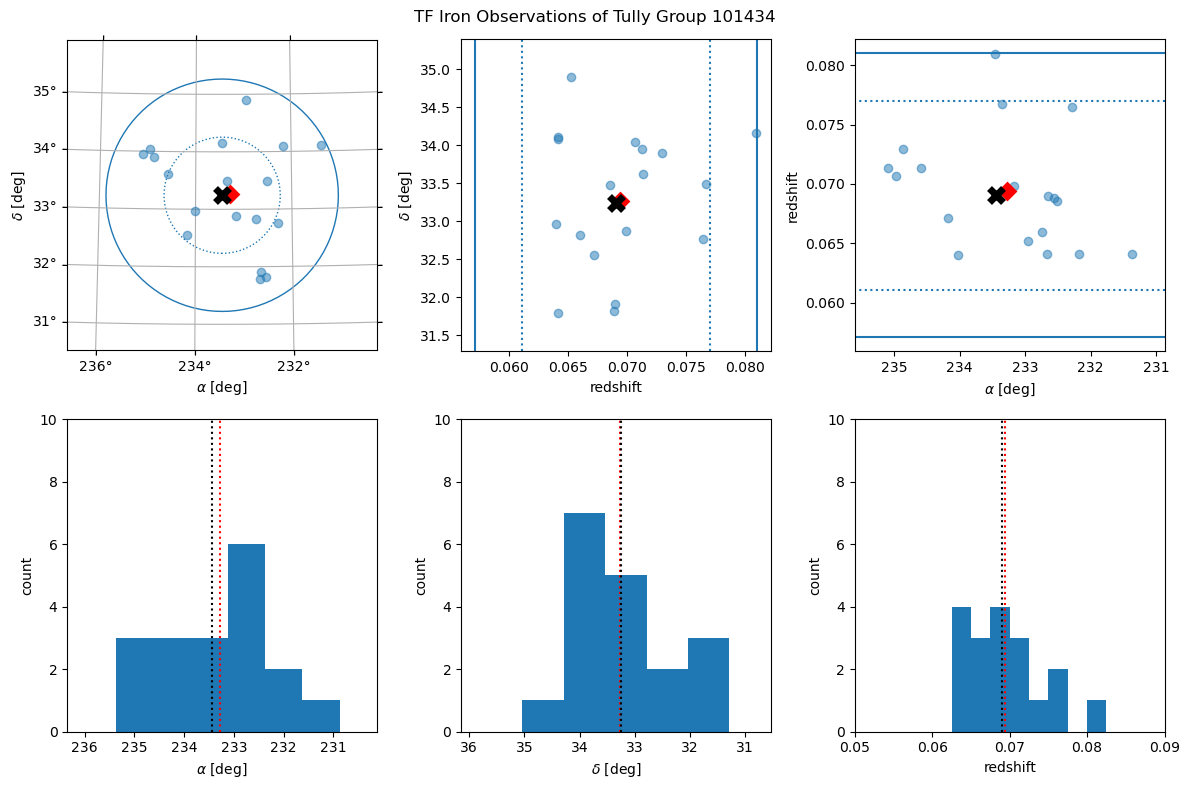

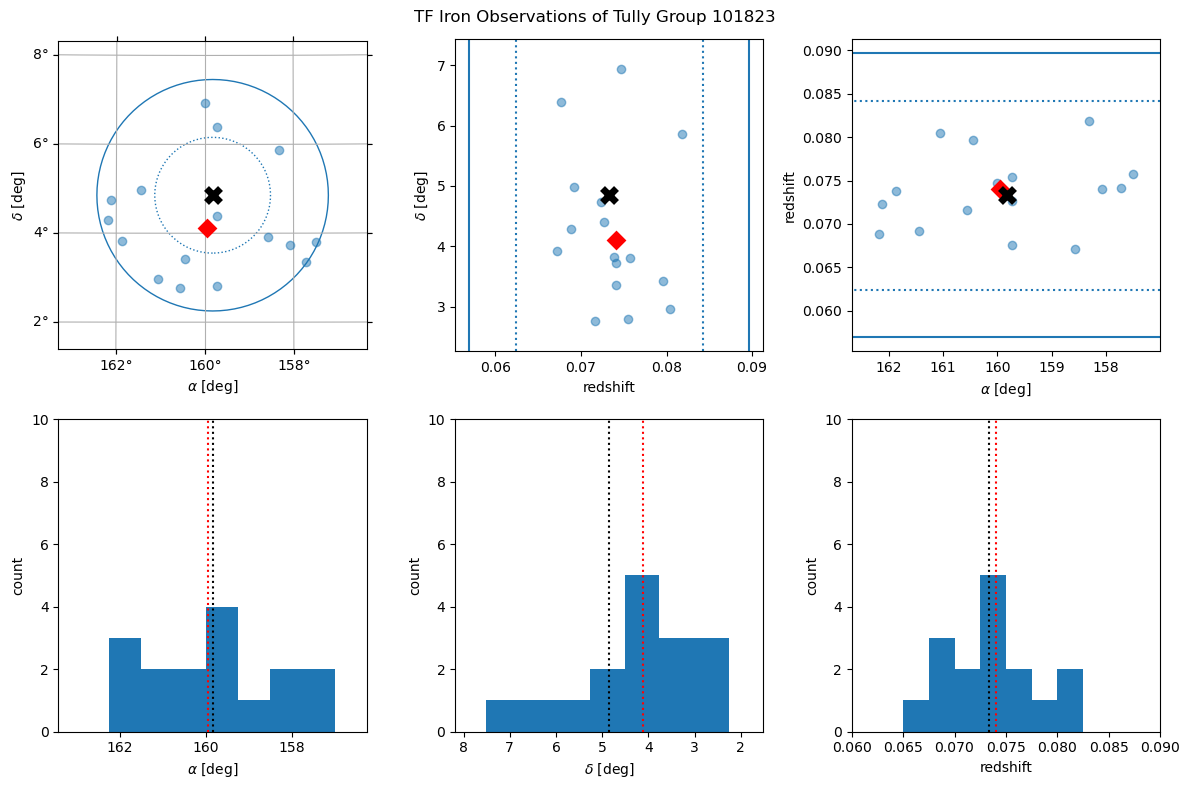

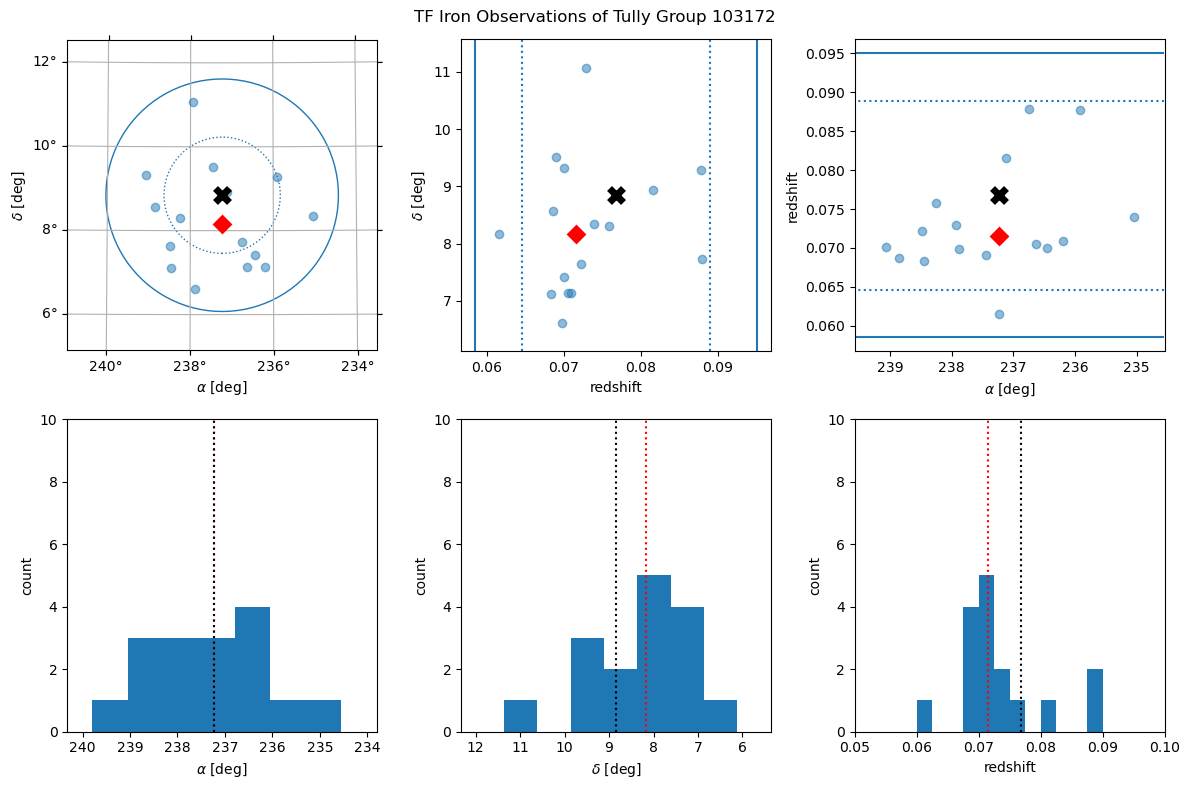

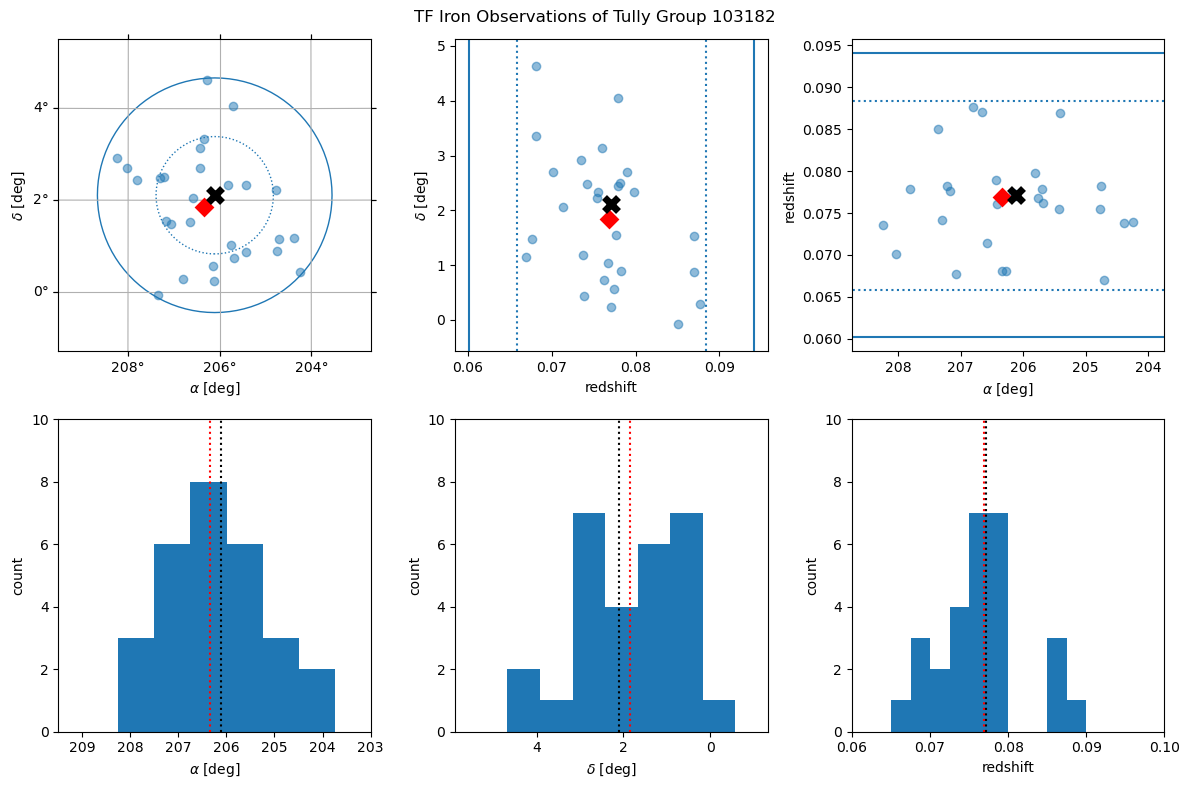

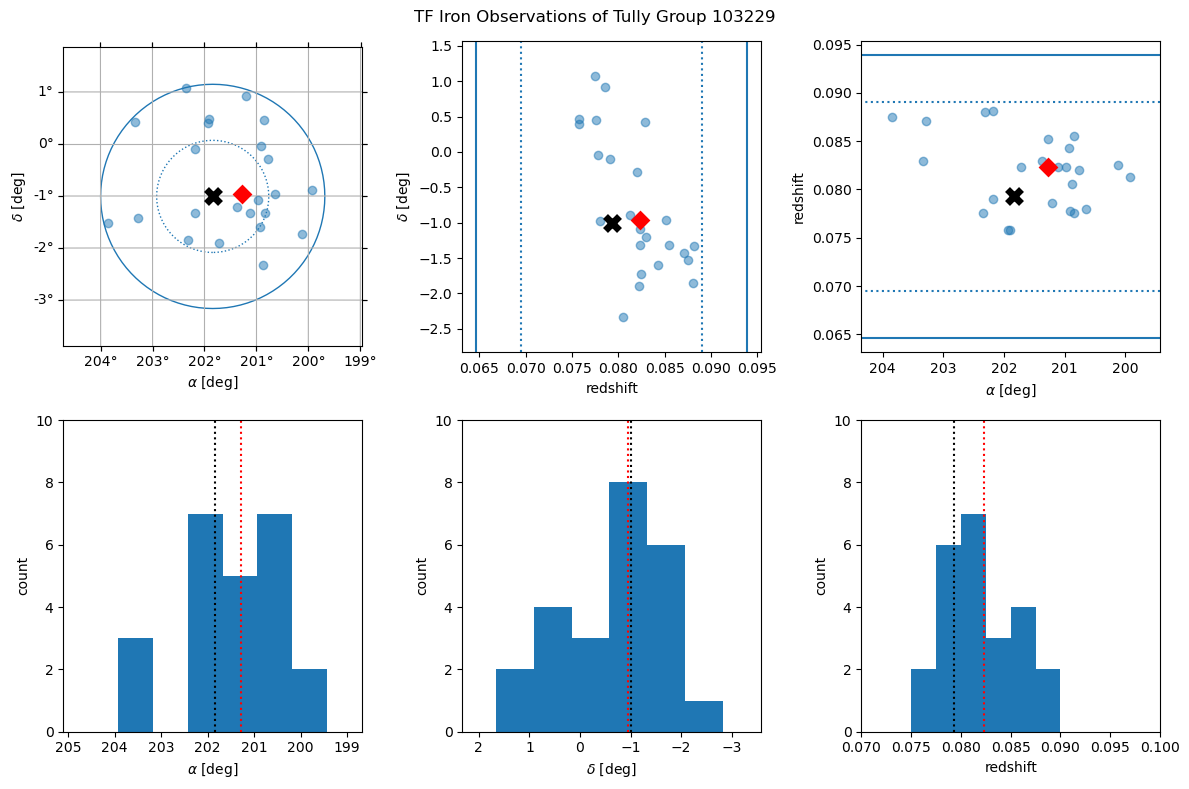

In [43]:
for cluster_id in sga_clusters.keys():
    if cluster_id in cluster_ids[select]:
        fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])
        # fig.savefig(f'../../Figures/Y1/TF_Y1_cluster_{cluster_id}_accept.png', dpi=150);

# Build the Calibration Table of SGA Galaxies in Clusters

In [44]:
caltab = None    # Table of selected clusters and SGA galaxies
rejtab = None    # Table of clusters failing the selection

for cluster_id, sga_ids in sga_clusters.items():
    if cluster_id in cluster_ids[select]:
        idx = np.in1d(sgatab['SGA_ID'], sga_ids)
        clustertab = sgatab[idx]
        clustertab['CLUSTER_ID'] = cluster_id
        
        caltab = clustertab if caltab is None else vstack([caltab, clustertab])
    else:
        idx = np.in1d(sgatab['SGA_ID'], sga_ids)
        clustertab = sgatab[idx]
        clustertab['CLUSTER_ID'] = cluster_id
        
        rejtab = clustertab if rejtab is None else vstack([rejtab, clustertab])

caltab.write('SGA-2020_iron_Vrot_cluster_calib_z0p1.fits', overwrite=True)
caltab[['CLUSTER_ID', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_err']]

<Table length=156>
CLUSTER_ID   SGA_ID  ...      V_0p4R26         V_0p4R26_err   
  int32     float64  ...      float64            float64      
---------- --------- ... ------------------ ------------------
    100067    8300.0 ...  123.6762255746927 3.7457133705293386
    100067   31987.0 ...  64.18726090256311 3.6954395261686637
    100067  125762.0 ... 150.38068986469068  2.132905733788766
    100067  186558.0 ...  84.74919158641427 11.452031788853317
    100067  196386.0 ... 130.66227829492158 2.1449436675665963
    100067  272387.0 ...  82.40365399731783 1.8441556929224312
    100067  279180.0 ... 133.02797033964302  2.433350827670689
    100067  374397.0 ... 118.34812104618656 1.3258503421070449
    100067  380891.0 ...  161.6861825053046 4.1693051269090775
    100067  432862.0 ... 100.26278507786748 2.9568707913490146
       ...       ... ...                ...                ...
    103229  714819.0 ... 112.92157124758103 2.6395075887133266
    103229  760816.0 ... 184.46005614673558  6.972924022362157
    103229  847416.0 ...  159.4238783043875  5.280025227134777
    103229  847995.0 ... 153.35183932864425 15.063694496847935
    103229  919187.0 ... 210.14326578113165   7.88063764141527
    103229  919531.0 ... 158.37794698690354  4.796252711098038
    103229 1001137.0 ... 185.26845058824017  6.367099472529035
    103229 1009175.0 ... 118.44444116876646  4.005425461782524
    103229 1028342.0 ... 125.43049898716905  3.788807418086909
    103229 1362643.0 ...   173.627543835745  5.627897689558202

In [45]:
# Save SGA IDs for each cluster that is part of the calibration (for Alex's Bayesian calibration)
for cluster in np.unique(caltab['CLUSTER_ID']):
    output_filename = 'output_' + str(cluster) + '.txt'
    # SGA_IDs_in_cluster = Table()
    # SGA_IDs_in_cluster['SGA_ID'] = c_4r_in_cluster[i]
    caltab[['SGA_ID']][caltab['CLUSTER_ID'] == cluster].write(output_filename, 
                                                              format='ascii.commented_header', 
                                                              overwrite=True)

In [46]:
rejtab

<Table length=154>
  SGA_ID     SGA_GALAXY             GALAXY         ... MORPHTYPE_AI CLUSTER_ID
                                                   ...                        
 float64      bytes16              bytes29         ...    str10       int32   
--------- ---------------- ----------------------- ... ------------ ----------
  33321.0   SGA-2020 33321  2MASXJ16035630+1401081 ...       Spiral     100007
 281765.0  SGA-2020 281765              PGC1434821 ...       Spiral     100007
 294344.0  SGA-2020 294344               PGC057248 ...       Spiral     100007
 295688.0  SGA-2020 295688               PGC091494 ...       Spiral     100007
 364205.0  SGA-2020 364205              PGC1468649 ...       Spiral     100007
 378878.0  SGA-2020 378878 SDSSJ160647.02+203220.1 ...       Spiral     100007
 547663.0  SGA-2020 547663               PGC056605 ...       Spiral     100007
 557038.0  SGA-2020 557038               PGC091480 ...       Spiral     100007
 841535.0  SGA-2020 841535 SDSSJ160420.50+141714.6 ...       Spiral     100007
      ...              ...                     ... ...          ...        ...
 813170.0  SGA-2020 813170              PGC1105184 ...       Spiral     103206
 814280.0  SGA-2020 814280              PGC1074367 ...       Spiral     103206
 992732.0  SGA-2020 992732              PGC1097938 ...       Spiral     103206
1079853.0 SGA-2020 1079853              PGC1069545 ...       Spiral     103206
1125115.0 SGA-2020 1125115              PGC1063527 ...       Spiral     103206
1172502.0 SGA-2020 1172502              PGC1091637 ...       Spiral     103206
1181551.0 SGA-2020 1181551              PGC1082776 ...       Spiral     103206
1261296.0 SGA-2020 1261296              PGC1086377 ...       Spiral     103206
1265122.0 SGA-2020 1265122              PGC1080425 ...       Spiral     103206
1435414.0 SGA-2020 1435414              PGC1081811 ...       Spiral     103206

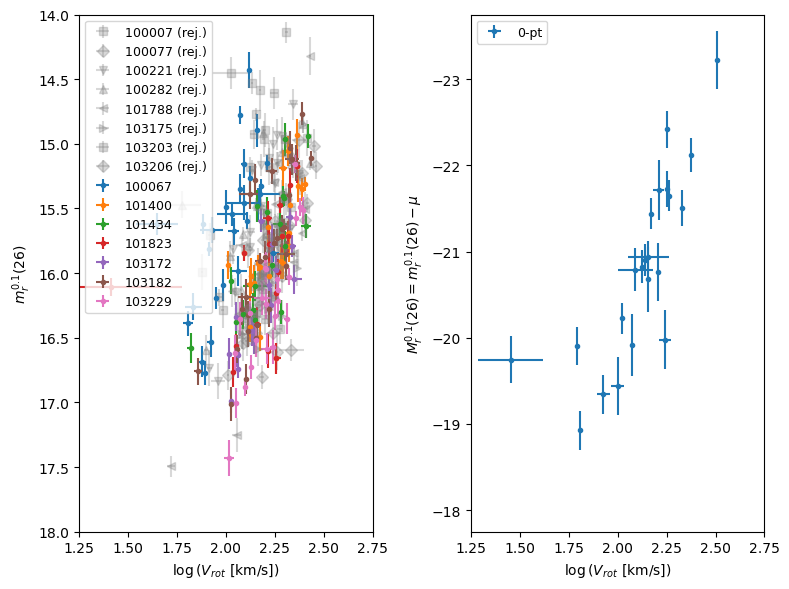

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)

logV0 = 0

ax = axes[0] 

#- Plot galaxies with failed cluster selections.
_cluster_ids = np.unique(rejtab['CLUSTER_ID'])
markers = 'sDv^<>'
for j, _cluster_id in enumerate(_cluster_ids):
    select_cluster = np.in1d(rejtab['CLUSTER_ID'], _cluster_id)

    #- Store independent variable for each cluster
    logv = np.log10(rejtab['V_0p4R26'][select_cluster].data) - logV0
    logv_err = 0.434*rejtab['V_0p4R26_err'][select_cluster].data / rejtab['V_0p4R26'][select_cluster].data

    #- Store dependent variable for each cluster
    mr26 = rejtab['R_MAG_SB26_CORR'][select_cluster].data
    mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_cluster].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                fmt=markers[j % 6], markersize=6, color='gray', alpha=0.3, label=f'{_cluster_id} (rej.)')

#- Plot galaxies and clusters passing all selections.
_cluster_ids = np.unique(caltab['CLUSTER_ID'])

for _cluster_id in _cluster_ids:
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_cluster].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_err'][select_cluster].data / caltab['V_0p4R26'][select_cluster].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_cluster].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_cluster].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label=f'{_cluster_id}')

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[18, 14],
       ylabel=r'$m_r^{0.1} (26)$')
ax.legend(loc='upper left', fontsize=9)

#- Plot the 0-pt calibrators
ax = axes[1]

logv = np.log10(zeroptab['V_0p4R26'].data) - logV0
logv_err = 0.434*zeroptab['V_0p4R26_err'].data / zeroptab['V_0p4R26'].data
mr26 = zeroptab['R_ABSMAG_SB26'].data
mr26_err = zeroptab['R_ABSMAG_SB26_err'].data

ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label='0-pt')
ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[-17.75, -23.75],
       ylabel=r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$')
ax.legend(loc='upper left', fontsize=9);

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_20241203.png', dpi=150);

# Apply the Joint TFR Fit

In [48]:
#- Extract successful clusters
_cluster_ids = np.unique(caltab['CLUSTER_ID'])
m = len(_cluster_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []

# logV0 = 2.25
logV0 = np.median(np.concatenate([np.log10(caltab['V_0p4R26']), 
                                  np.log10(zeroptab['V_0p4R26'])]))
print('logV0 =', logV0)

# Start with the zero-point calibrators
logV.append(np.log10(zeroptab['V_0p4R26']) - logV0)
logV_err.append(0.434*zeroptab['V_0p4R26_err'] / zeroptab['V_0p4R26'])
mag.append(zeroptab['R_ABSMAG_SB26'])
mag_err.append(zeroptab['R_ABSMAG_SB26_err'])

#- Loop over the SGA clusters
for k, _cluster_id in enumerate(_cluster_ids):
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_cluster]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_err'][select_cluster] / caltab['V_0p4R26'][select_cluster])
    mag.append(caltab['R_MAG_SB26_CORR'][select_cluster])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_cluster])

logV0 = 2.176886309712498


## Multiline Fit using HyperFit

In [49]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + clusters)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -8224.039097082044
     jac: array([-0.23064786, -0.14351825, -0.2022716 ,  0.03165041,  0.14588294,
       -0.36015987, -0.07694325,  0.03092282,  0.11132214,  0.14788384])
 message: 'Optimization terminated successfully.'
    nfev: 19149
     nit: 126
 success: True
       x: array([ -6.10865294, -21.12368453,  14.74761698,  16.19687494,
        15.9797703 ,  16.24203141,  16.17120889,  16.05715173,
        16.47543686,   0.45294816])
Ndim: 10 8


100%|██████████| 1000/1000 [00:21<00:00, 46.58it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [57.38937779 54.05232025 55.70007849 50.47578847 58.02301613 58.61678983
 54.6217924  61.90771212 54.51195349 54.61121149] / 3095.385606063706


100%|██████████| 1000/1000 [00:18<00:00, 52.69it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [64.62664454 68.47423949 65.52678358 65.91977932 62.30941642 64.56348426
 70.33991245 69.93010787 69.35047639 62.40753313] / 3516.9956226541417


100%|██████████| 1000/1000 [00:17<00:00, 55.68it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [72.1365965  71.61340637 72.56076864 69.74282976 77.5506956  75.38537411
 74.39580603 78.41951852 82.13094897 67.26922086] / 4106.547448517147


100%|██████████| 1000/1000 [00:19<00:00, 50.43it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [75.52875721 70.84254636 77.91975949 77.46729474 88.33775347 83.94482415
 70.58461535 80.78457769 77.08132116 77.66316667] / 4416.887673328737


100%|██████████| 1000/1000 [00:19<00:00, 51.92it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [85.53435438 86.80719529 80.9860538  91.74097143 87.26934004 85.75769722
 74.71880991 74.71712762 80.43131038 83.97691887] / 4587.048571373491


100%|██████████| 1000/1000 [00:20<00:00, 49.40it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [86.35866712 91.31241998 85.99515733 90.32888027 94.19299091 80.04410518
 81.39173274 78.99441942 80.61088691 84.99064435] / 4709.649545499129


100%|██████████| 1000/1000 [00:19<00:00, 50.49it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [82.81860041 99.58356958 86.89233745 86.38583157 96.68588003 83.31889804
 83.93560457 78.89075024 82.6800489  86.52028832] / 4979.178478924273


100%|██████████| 1000/1000 [00:19<00:00, 52.47it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [89.54683087 97.16660187 85.58200903 84.13055599 99.35966086 82.36577419
 85.77905083 78.63979073 83.79784031 92.12750497] / 4967.983043141705


100%|██████████| 1000/1000 [00:20<00:00, 49.02it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 97.8200942   94.95153273  93.89036384  85.16255111 101.18541585
  92.9687642   86.16074807  83.63989773  84.98723102  92.86395373] / 5059.270792384924


100%|██████████| 1000/1000 [00:18<00:00, 55.41it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 95.1936333   91.57253051  92.51370662  86.58574603 103.02332179
  92.79731158  86.72576713  91.18268342  83.35819264  89.33526951] / 5151.166089684392


100%|██████████| 1000/1000 [00:20<00:00, 49.42it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 97.11872595  89.38954656  96.22331921  84.56886947 103.37671319
  94.57987163  89.4226674   97.98756795  87.21284239  86.36234862] / 5168.8356593968365


100%|██████████| 1000/1000 [00:19<00:00, 51.88it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [95.9939882  92.17392741 97.33178548 86.64877193 96.14620173 95.61931074
 90.58145824 99.44171882 93.02527603 89.15918606] / 4972.085941112491


100%|██████████| 1000/1000 [00:16<00:00, 60.29it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 99.14799649  96.26528771 104.78190363  88.98626848 100.93162803
  97.41105832  91.93361574 100.65379105  91.63443487  92.78338789] / 5239.095181649098


100%|██████████| 1000/1000 [00:20<00:00, 49.96it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [101.42238844  93.85097361 101.88039595  91.35124114 102.04229727
 104.48246132  92.665573   104.1009921   98.46004617  98.02729677] / 5224.123065859835


100%|██████████| 1000/1000 [00:18<00:00, 55.28it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [101.76846849  97.41596893 105.93123583  92.14472342 106.13712218
 107.19204997  91.61140555 109.82289637 103.60545955  98.46121263] / 5491.144818320275


100%|██████████| 1000/1000 [00:18<00:00, 54.13it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [102.58578343  94.2384893  108.18806586  96.36664435 105.95914686
 108.78194528  96.82739476 108.08504431 100.99987289 101.13697494] / 5439.097264188984


100%|██████████| 1000/1000 [00:18<00:00, 55.28it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [104.24023815  92.94871934 107.4310292   95.37250835 108.69579045
 110.01376363  99.54182265 104.50405631 101.15729919 104.56977567] / 5500.6881813052405


In [50]:
temp_outfile = open('cov_ab_iron_jointTFR_varyV0-perpdwarfs0_z0p1_binaryMLupdated_KAD-20241220.pickle', 'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0), temp_outfile)
temp_outfile.close()

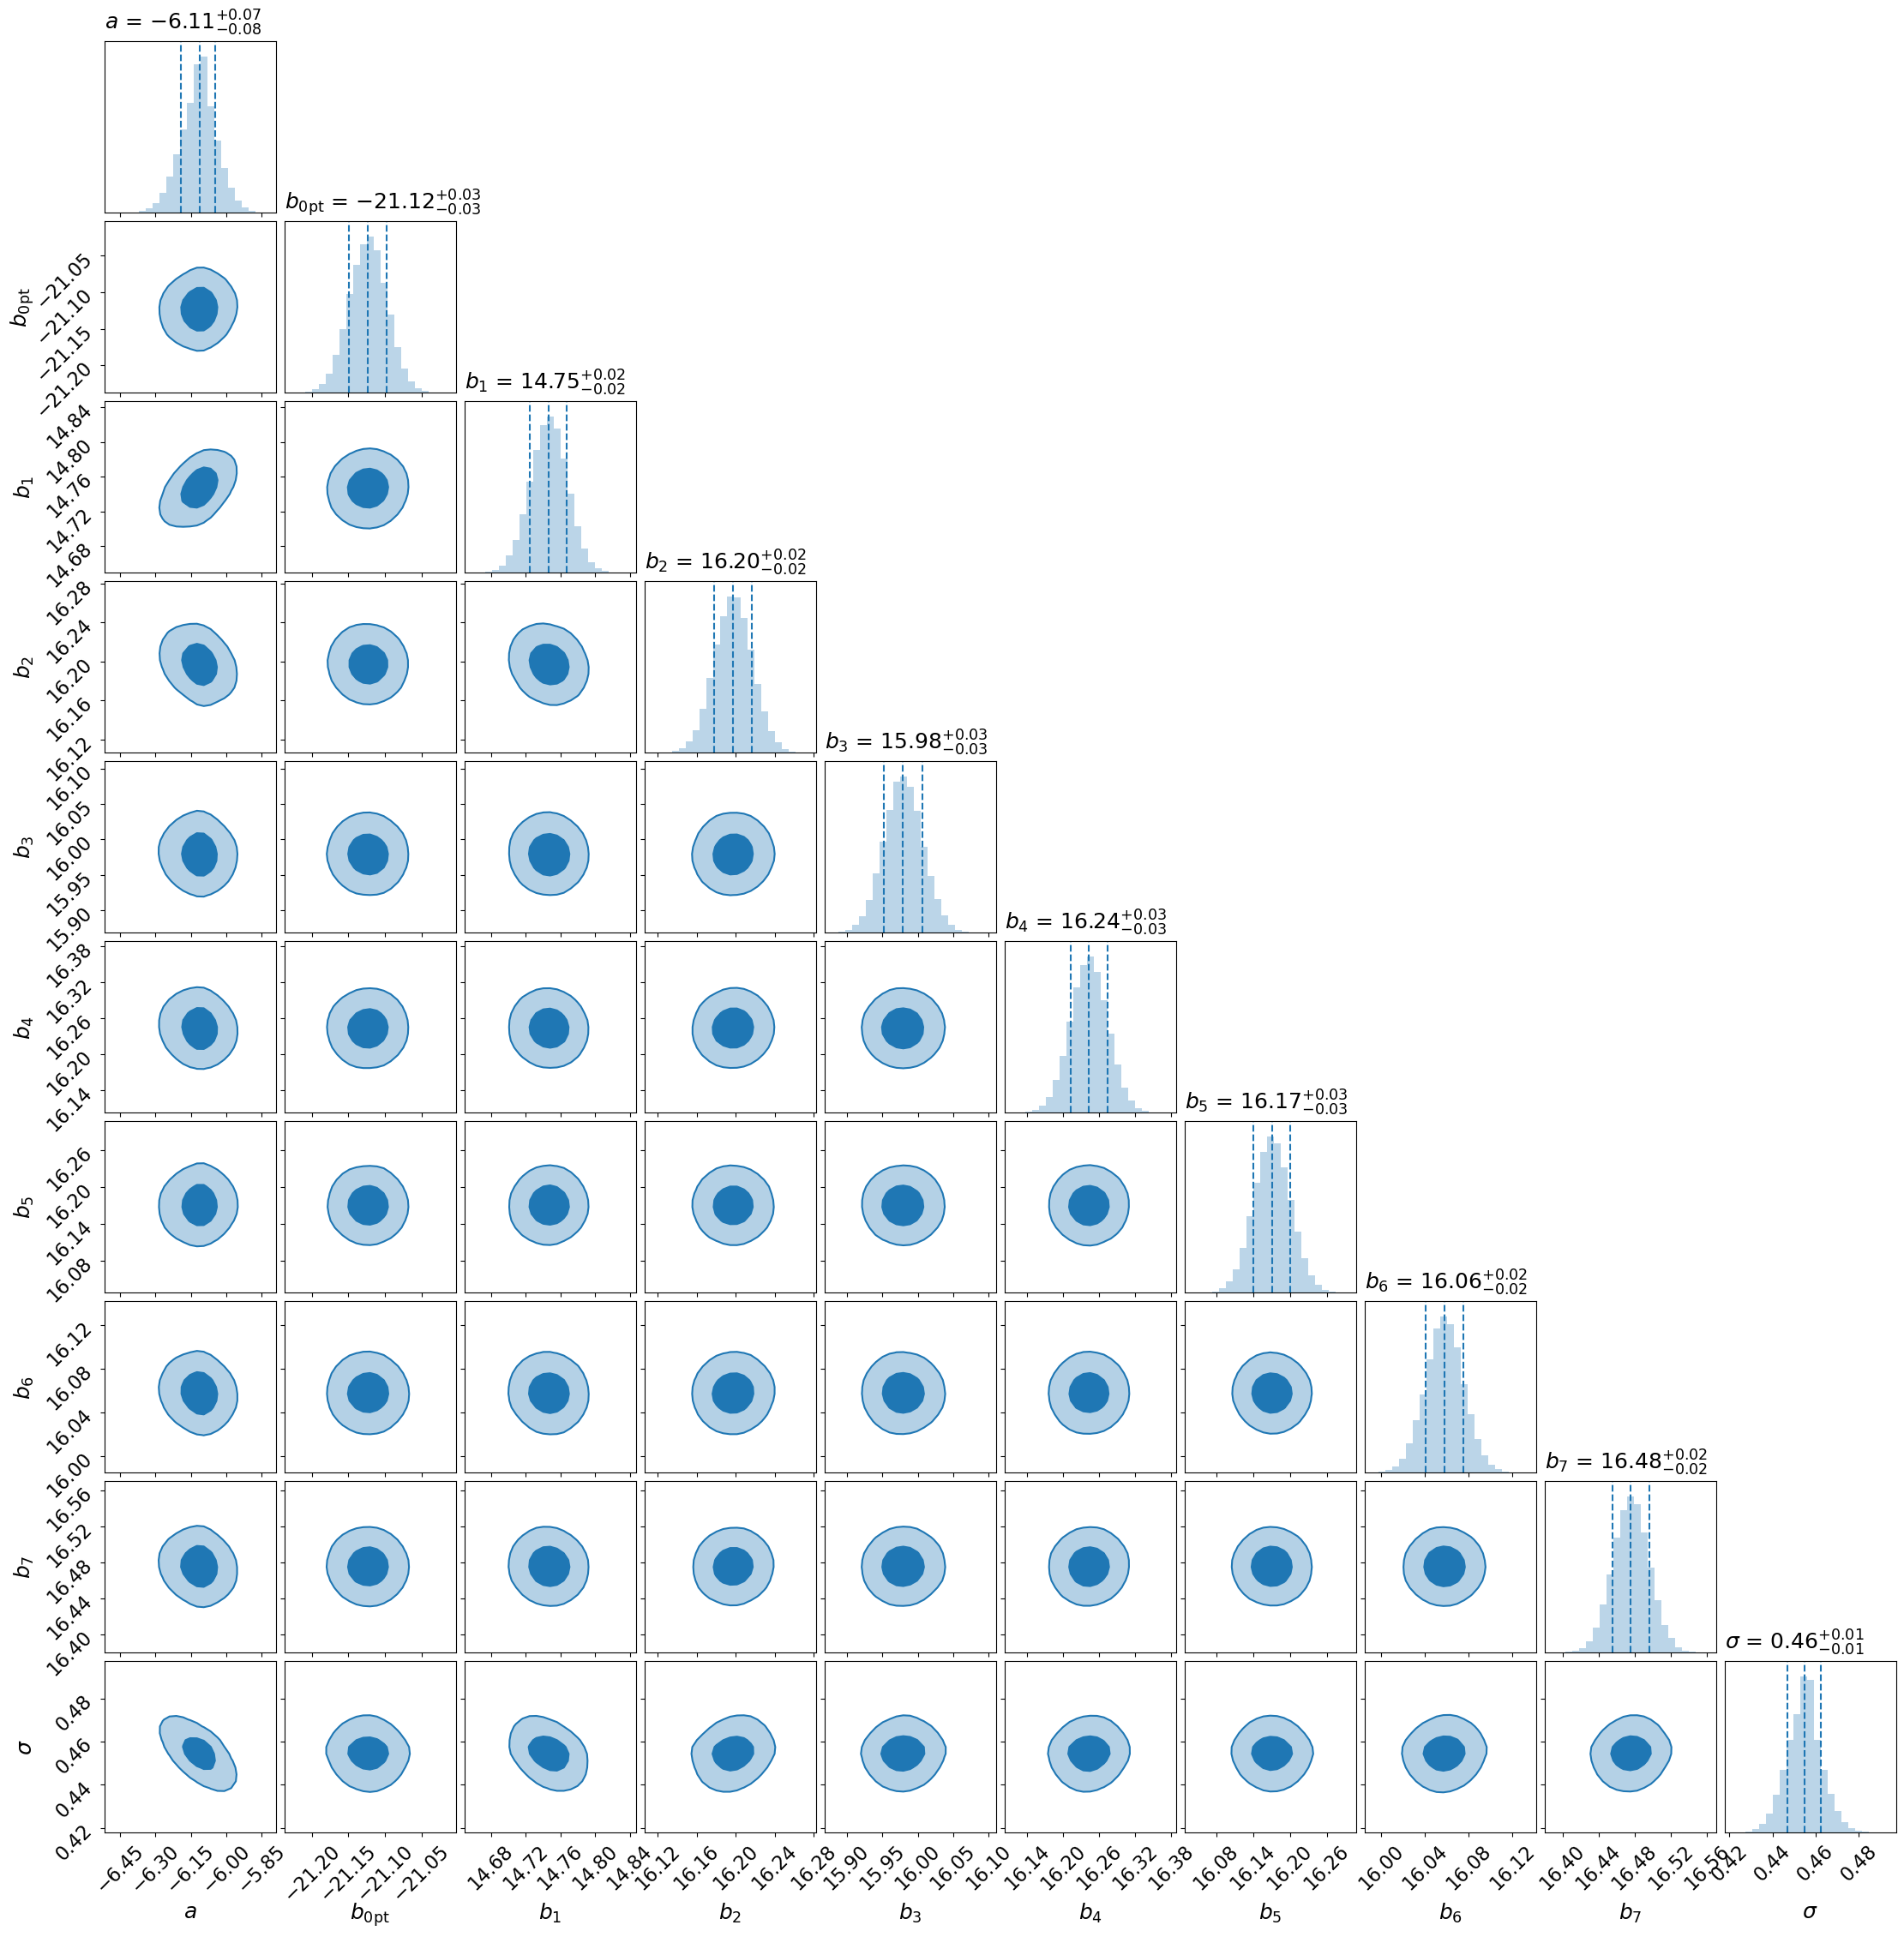

In [51]:
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$'] + [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_binaryMLupdated_z0p1_corner0_20241220.png', dpi=150,facecolor='none');

### Plot the HyperFit Results

In [52]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+2):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

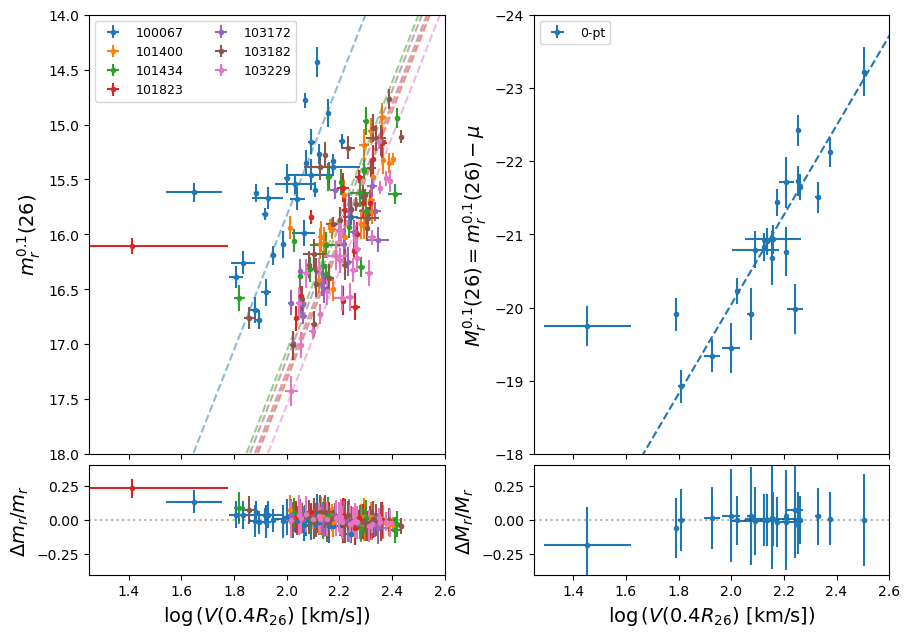

In [53]:
fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot clusters
ax = axes[0,0]

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV[k+1] + logV0, y=mag[k+1], xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_cluster_ids[k]}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)#, label='fit')

ax.set(xlim=[1.25, 2.6],
       ylim=[18, 14]
      )
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2);

#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='.', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[1.25, 2.6],
       ylim=[-18, -24]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2)

#- Plot residuals: clusters
ax = axes[1,0]

for k in range(m):
    logv_obs = logV[k+1]
    m_obs = mag[k+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_cluster_ids[k]}')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[0], yerr=mag_err[0],
                     fmt='.', label=f'0-pt')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);
# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_z0p1_fit0_20241220.png', dpi=150, facecolor='none')

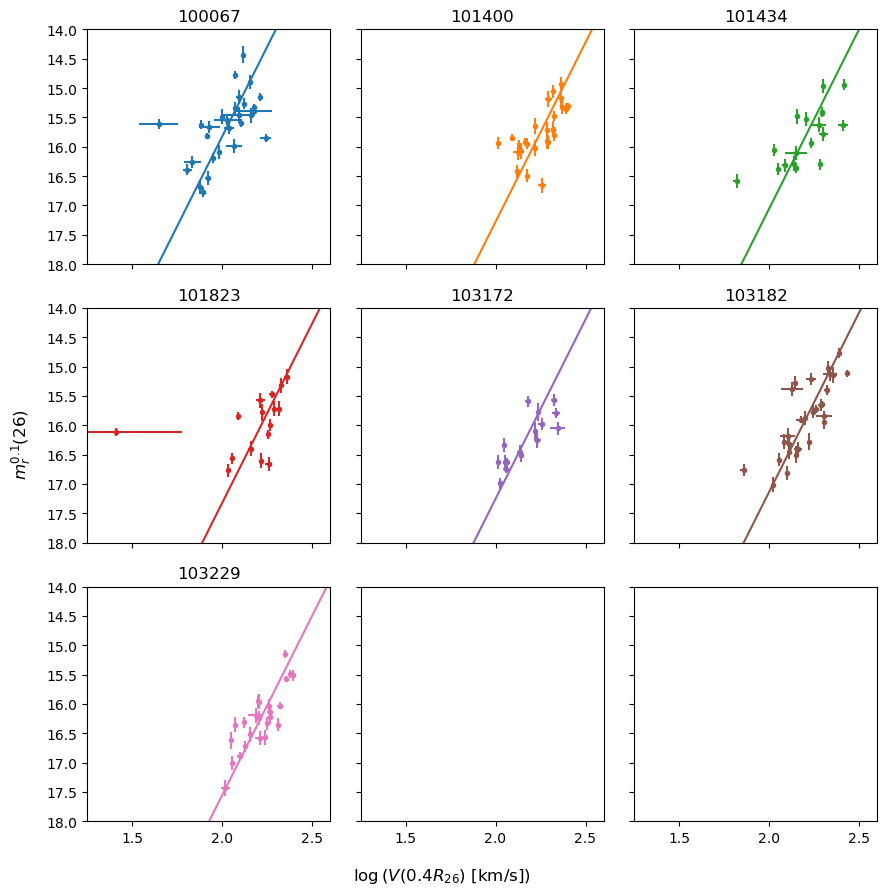

In [54]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(9,9), tight_layout=True)

color = iter(plt.get_cmap('tab10').colors)
for i in range(m):
    c = next(color)
    
    row = int(i/3)
    col = i%3
    
    eb = axs[row,col].errorbar(logV[i+1] + logV0, mag[i+1], xerr=logV_err[i+1], yerr=mag_err[i+1], fmt='.', color=c)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.25, 2.6], ylim=[18, 14], title=f'{_cluster_ids[i]}')
    
fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

### Does this calibration result in any dwarf galaxies?

Dwarf galaxies are defined as those below the line perpendicular to the calibration where $M_r > -17$.

#### Define the line perpendicular to the calibration

In [55]:
logV_n17 = (-17 - b0pt)/a_ + logV0
# b_perp = -17 + (logV_n17 - logV0)/a_
# b_perp

mr_n17 = a_*(logV_n17 - logV0) + b_
b_perp = mr_n17 + (logV_n17 - logV0)/a_

print(10**logV_n17, 'km/s')

31.807465004267062 km/s


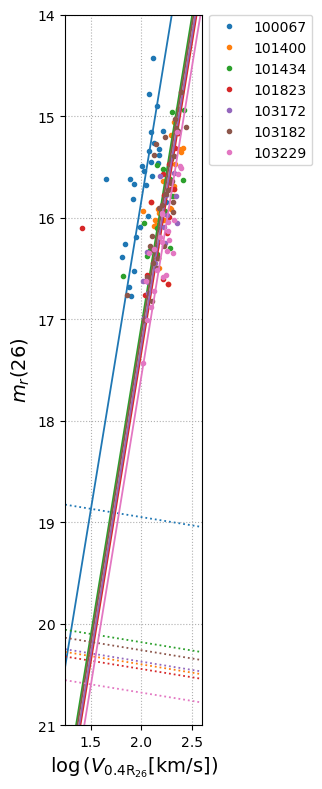

In [56]:
plt.figure(figsize=(4,8), tight_layout=True)

ax = plt.gca()

plt.grid(ls=':')

for k in range(m):
    eb = plt.plot(logV[k+1] + logV0, mag[k+1], '.', label=f'{_cluster_ids[k]}')
    plt.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), marker='None', ls='-', lw=1.3)
    plt.plot(_logv + logV0, -_logv/a_ + b_perp[k], color=eb[0].get_color(), marker='None', ls=':', lw=1.3)
    # plt.hlines(m_dwarf_clusters[_cluster_ids[k]], 1.25, 2.75, colors=eb[0].get_color(), linestyles='dashed')
    
plt.xlabel(r'$\log{(V_\mathrm{0.4R_{26}} [\mathrm{km/s}])}$', fontsize=14)
plt.ylabel(r'$m_r (26)$', fontsize=14)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.xlim(1.25, 2.6)
plt.ylim(21, 14)

plt.gca().set_aspect('equal');

#### Filter out the dwarf galaxies

Those below the line
\begin{equation}
  m_r = -(\log(V(0.4R_{26})) - V_0)/a + b_{\rm cluster \perp}
\end{equation}

In [57]:
dwarfs = np.zeros(len(caltab), dtype=bool)

for i in range(m):
    # Retrieve this cluster's nest ID
    nestid = _cluster_ids[i]
    
    # Find all galaxies in this cluster
    cluster_gal_idx = caltab['CLUSTER_ID'] == nestid
    
    # Find which of these cluster galaxies are dwarfs
    cluster_dwarfs = (caltab['R_MAG_SB26_CORR'][cluster_gal_idx] - caltab['R_MAG_SB26_ERR_CORR'][cluster_gal_idx]) > (-(np.log10(caltab['V_0p4R26'][cluster_gal_idx]) - logV0)/a_ + b_perp[k])
    
    # Set the boolean correctly
    dwarfs[cluster_gal_idx] = cluster_dwarfs
    
caltab_bright = caltab[~dwarfs]

print(np.sum(dwarfs))

0
